## 1. Environment Setup and Library Imports

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from pathlib import Path
import warnings
import time
warnings.filterwarnings('ignore')

# PyTorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Sklearn for cross-validation
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# Albumentations for augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Transformers for SegFormer
from transformers import SegformerForSemanticSegmentation

# torchsummary for model summary
try:
    from torchsummary import summary
    TORCHSUMMARY_AVAILABLE = True
except ImportError:
    TORCHSUMMARY_AVAILABLE = False
    print("torchsummary not available. Install with: pip install torchsummary")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

2025-07-27 13:21:40.939334: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753622501.097759      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753622501.151703      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


## 2. Data Exploration and Analysis

In [2]:
# Data path configuration
data_root = '/kaggle/input/USA_segmentation'
mask_dir = os.path.join(data_root, 'masks')
rgb_dir = os.path.join(data_root, 'RGB_images')
nrg_dir = os.path.join(data_root, 'NRG_images')

# Check if data directories exist
for directory in [mask_dir, rgb_dir, nrg_dir]:
    if not os.path.exists(directory):
        print(f'Warning: Directory {directory} does not exist!')
    else:
        print(f'Directory {directory} exists')

# Get file lists
mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.png')))
rgb_files = sorted(glob.glob(os.path.join(rgb_dir, '*.png')))
nrg_files = sorted(glob.glob(os.path.join(nrg_dir, '*.png')))

print(f'Found {len(mask_files)} mask files')
print(f'Found {len(rgb_files)} RGB files')
print(f'Found {len(nrg_files)} NRG files')

Directory /kaggle/input/USA_segmentation/masks exists
Directory /kaggle/input/USA_segmentation/RGB_images exists
Directory /kaggle/input/USA_segmentation/NRG_images exists
Found 444 mask files
Found 444 RGB files
Found 444 NRG files


In [3]:
# Data filename correspondence check
def extract_filename_key(filepath):
    """Extract key identifier from file path"""
    filename = os.path.basename(filepath)
    # Remove corresponding prefix based on filename prefix
    if filename.startswith('mask_'):
        return filename[5:]  # Remove 'mask_' prefix
    elif filename.startswith('RGB_'):
        return filename[4:]  # Remove 'RGB_' prefix
    elif filename.startswith('NRG_'):
        return filename[4:]  # Remove 'NRG_' prefix
    return filename

# Check filename correspondence
mask_keys = [extract_filename_key(f) for f in mask_files]
rgb_keys = [extract_filename_key(f) for f in rgb_files]
nrg_keys = [extract_filename_key(f) for f in nrg_files]

print(f'Sample mask keys: {mask_keys[:5]}')
print(f'Sample RGB keys: {rgb_keys[:5]}')
print(f'Sample NRG keys: {nrg_keys[:5]}')

# Find common files across all three data types
common_keys = set(mask_keys) & set(rgb_keys) & set(nrg_keys)
print(f'Common files across all three types: {len(common_keys)}')

# Create matched file list
matched_files = []
for key in common_keys:
    mask_file = next((f for f in mask_files if extract_filename_key(f) == key), None)
    rgb_file = next((f for f in rgb_files if extract_filename_key(f) == key), None)
    nrg_file = next((f for f in nrg_files if extract_filename_key(f) == key), None)
    
    if mask_file and rgb_file and nrg_file:
        matched_files.append({
            'key': key,
            'mask': mask_file,
            'rgb': rgb_file,
            'nrg': nrg_file
        })

print(f'Successfully matched {len(matched_files)} files')

Sample mask keys: ['ar037_2019_n_06_04_0.png', 'ar037_2019_n_07_05_0.png', 'ar037_2019_n_07_17_1.png', 'ar037_2019_n_08_14_0.png', 'ar037_2019_n_13_13_0.png']
Sample RGB keys: ['ar037_2019_n_06_04_0.png', 'ar037_2019_n_07_05_0.png', 'ar037_2019_n_07_17_1.png', 'ar037_2019_n_08_14_0.png', 'ar037_2019_n_13_13_0.png']
Sample NRG keys: ['ar037_2019_n_06_04_0.png', 'ar037_2019_n_07_05_0.png', 'ar037_2019_n_07_17_1.png', 'ar037_2019_n_08_14_0.png', 'ar037_2019_n_13_13_0.png']
Common files across all three types: 444
Successfully matched 444 files


Dead tree ratio statistics:
Mean: 0.0189
Median: 0.0132
Std: 0.0177
Min: 0.0000
Max: 0.1272


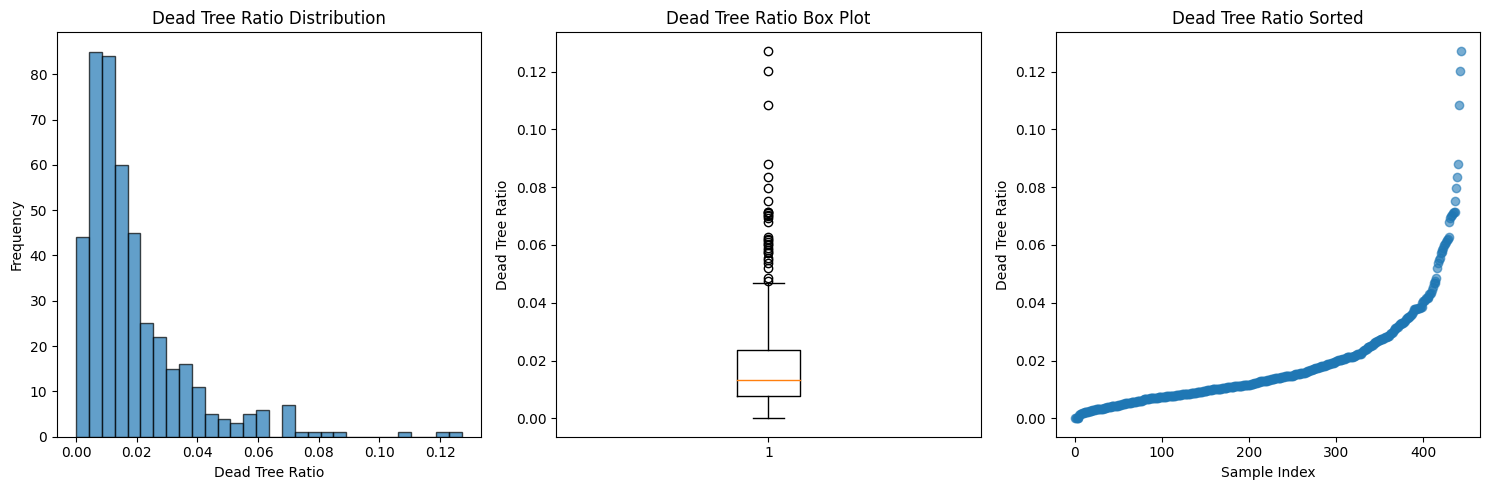

In [4]:
# Dead tree pixel ratio statistics
def calculate_dead_tree_ratio(mask_path):
    """Calculate dead tree pixel ratio"""
    try:
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            return 0.0
        
        # Assume dead tree pixels are non-zero values
        dead_tree_pixels = np.sum(mask > 0)
        total_pixels = mask.size
        
        return dead_tree_pixels / total_pixels if total_pixels > 0 else 0.0
    except Exception as e:
        print(f'Error processing {mask_path}: {e}')
        return 0.0

# Calculate dead tree ratio for each mask
dead_tree_ratios = []
for file_info in matched_files:
    ratio = calculate_dead_tree_ratio(file_info['mask'])
    dead_tree_ratios.append(ratio)
    file_info['dead_tree_ratio'] = ratio

# Statistical analysis
ratios_array = np.array(dead_tree_ratios)
print(f'Dead tree ratio statistics:')
print(f'Mean: {np.mean(ratios_array):.4f}')
print(f'Median: {np.median(ratios_array):.4f}')
print(f'Std: {np.std(ratios_array):.4f}')
print(f'Min: {np.min(ratios_array):.4f}')
print(f'Max: {np.max(ratios_array):.4f}')

# Visualize dead tree ratio distribution
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(ratios_array, bins=30, alpha=0.7, edgecolor='black')
plt.title('Dead Tree Ratio Distribution')
plt.xlabel('Dead Tree Ratio')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.boxplot(ratios_array)
plt.title('Dead Tree Ratio Box Plot')
plt.ylabel('Dead Tree Ratio')

plt.subplot(1, 3, 3)
plt.scatter(range(len(ratios_array)), sorted(ratios_array), alpha=0.6)
plt.title('Dead Tree Ratio Sorted')
plt.xlabel('Sample Index')
plt.ylabel('Dead Tree Ratio')

plt.tight_layout()
plt.show()

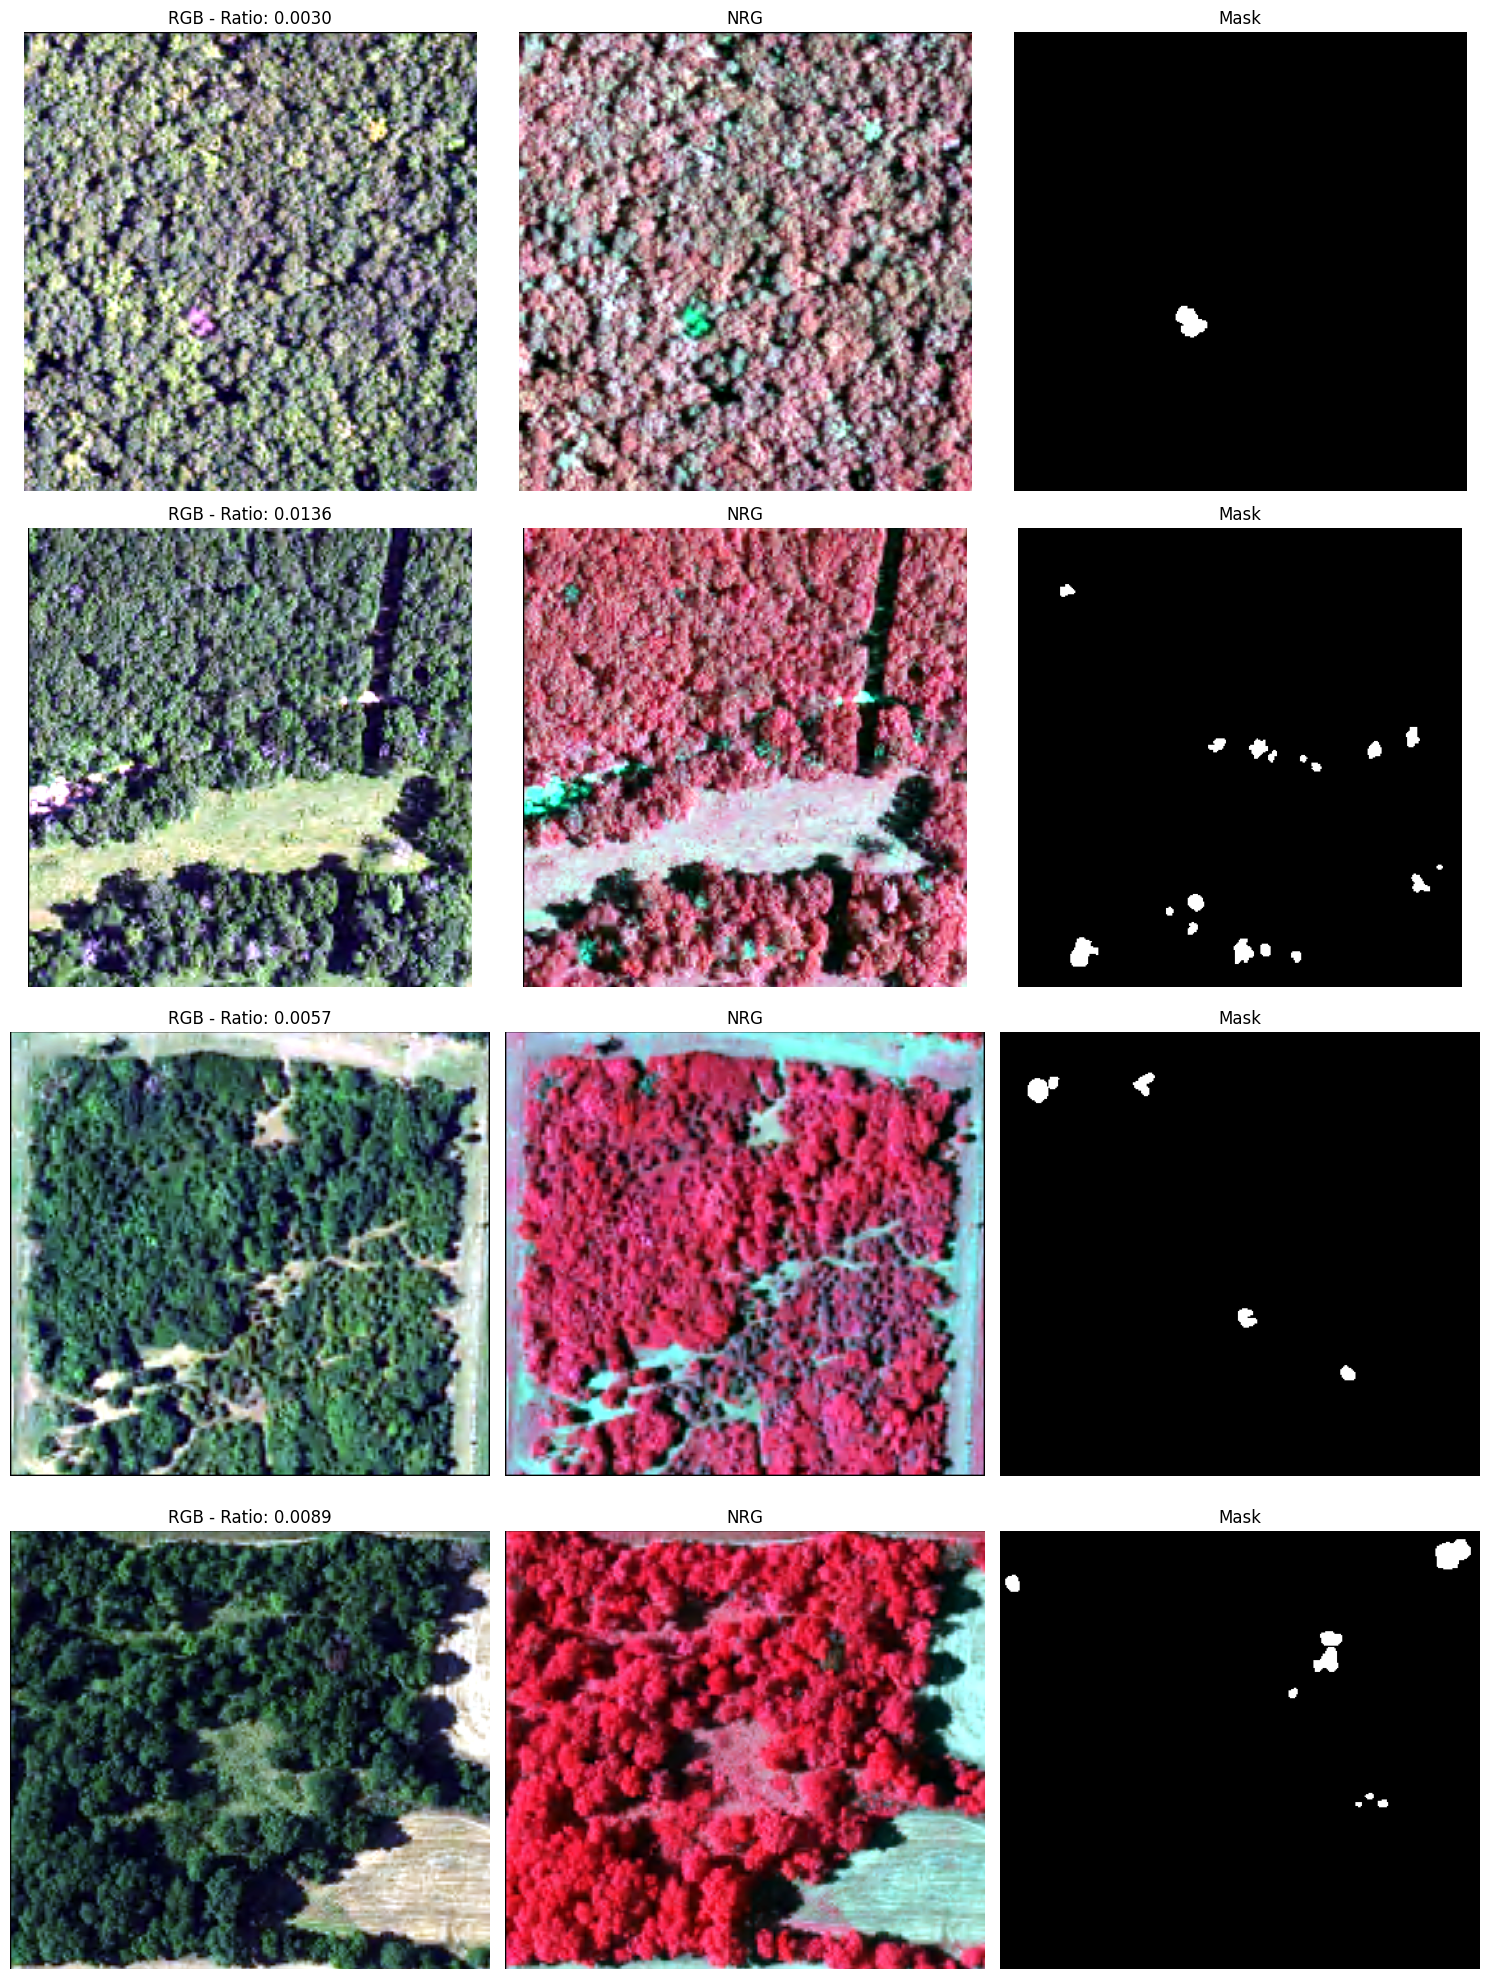

In [5]:
# Sample image visualization
def visualize_samples(matched_files, num_samples=4):
    """Visualize sample images"""
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
    
    # Ensure axes is always 2D for consistent indexing
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    sample_indices = np.random.choice(len(matched_files), num_samples, replace=False)
    
    for i, idx in enumerate(sample_indices):
        file_info = matched_files[idx]
        
        # Load images
        try:
            rgb_img = cv2.imread(file_info['rgb'])
            rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)
            
            nrg_img = cv2.imread(file_info['nrg'])
            nrg_img = cv2.cvtColor(nrg_img, cv2.COLOR_BGR2RGB)
            
            mask_img = cv2.imread(file_info['mask'], cv2.IMREAD_GRAYSCALE)
            
            # Display images
            axes[i, 0].imshow(rgb_img)
            axes[i, 0].set_title(f'RGB - Ratio: {file_info["dead_tree_ratio"]:.4f}')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(nrg_img)
            axes[i, 1].set_title('NRG')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(mask_img, cmap='gray')
            axes[i, 2].set_title('Mask')
            axes[i, 2].axis('off')
            
        except Exception as e:
            print(f'Error loading images for sample {idx}: {e}')
    
    plt.tight_layout()
    plt.show()

visualize_samples(matched_files)

## 3. Stratified K-Fold Cross Validation Implementation

In [6]:
# Stratified split function
def create_stratified_splits(matched_files, n_splits=5, test_size=0.2):
    """Create stratified K-fold splits"""
    # Extract dead tree ratios
    ratios = [f['dead_tree_ratio'] for f in matched_files]
    
    # Create stratification labels (low, medium, high content)
    ratio_percentiles = np.percentile(ratios, [33, 67])
    stratify_labels = []
    
    for ratio in ratios:
        if ratio <= ratio_percentiles[0]:
            stratify_labels.append(0)  # Low content
        elif ratio <= ratio_percentiles[1]:
            stratify_labels.append(1)  # Medium content
        else:
            stratify_labels.append(2)  # High content
    
    print(f'Stratification distribution:')
    unique, counts = np.unique(stratify_labels, return_counts=True)
    for label, count in zip(unique, counts):
        print(f'  Class {label}: {count} samples ({count/len(stratify_labels)*100:.1f}%)')
    
    # First split test set
    from sklearn.model_selection import train_test_split
    
    indices = np.arange(len(matched_files))
    train_val_idx, test_idx = train_test_split(
        indices, test_size=test_size, stratify=stratify_labels, random_state=42
    )
    
    # Create K-fold cross validation
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    train_val_labels = [stratify_labels[i] for i in train_val_idx]
    
    folds = []
    for fold_idx, (train_idx, val_idx) in enumerate(skf.split(train_val_idx, train_val_labels)):
        fold_train_idx = train_val_idx[train_idx]
        fold_val_idx = train_val_idx[val_idx]
        
        fold_info = {
            'fold': fold_idx,
            'train_idx': fold_train_idx,
            'val_idx': fold_val_idx,
            'test_idx': test_idx
        }
        folds.append(fold_info)
    
    return folds, stratify_labels

# Create stratified K-fold splits
folds, stratify_labels = create_stratified_splits(matched_files, n_splits=5, test_size=0.2)

print(f'\nCreated {len(folds)} folds')
for i, fold in enumerate(folds):
    print(f'Fold {i}: Train={len(fold["train_idx"])}, Val={len(fold["val_idx"])}, Test={len(fold["test_idx"])}')

Stratification distribution:
  Class 0: 147 samples (33.1%)
  Class 1: 150 samples (33.8%)
  Class 2: 147 samples (33.1%)

Created 5 folds
Fold 0: Train=284, Val=71, Test=89
Fold 1: Train=284, Val=71, Test=89
Fold 2: Train=284, Val=71, Test=89
Fold 3: Train=284, Val=71, Test=89
Fold 4: Train=284, Val=71, Test=89


## 4. Data Loader Implementation

In [7]:
class DeadTreeDataset(Dataset):
    """Dead tree segmentation dataset"""
    
    def __init__(self, matched_files, indices, input_type='rgb', transform=None, target_size=(256, 256)):
        """
        Args:
            matched_files: List of matched files
            indices: Data indices
            input_type: 'rgb', 'nrg' or 'rgb_nir'
            transform: Data augmentation
            target_size: Target image size
        """
        self.matched_files = matched_files
        self.indices = indices
        self.input_type = input_type
        self.transform = transform
        self.target_size = target_size
        
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        file_idx = self.indices[idx]
        file_info = self.matched_files[file_idx]
        
        if self.input_type == 'rgb':
            image = cv2.imread(file_info['rgb'])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        elif self.input_type == 'nrg':
            image = cv2.imread(file_info['nrg'])
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        elif self.input_type == 'rgb_nir':
            # Load RGB
            rgb_img = cv2.imread(file_info['rgb'])
            rgb_img = cv2.cvtColor(rgb_img, cv2.COLOR_BGR2RGB)
            # Load NRG, take NIR channel (assume NIR is channel 0)
            nrg_img = cv2.imread(file_info['nrg'])
            nrg_img = cv2.cvtColor(nrg_img, cv2.COLOR_BGR2RGB)
            nir_channel = nrg_img[:, :, 0]
            # Combine to 4 channels
            image = np.concatenate([rgb_img, nir_channel[..., None]], axis=2)
        else:
            raise ValueError(f"Unknown input_type: {self.input_type}")
        
        # Load mask
        mask = cv2.imread(file_info['mask'], cv2.IMREAD_GRAYSCALE)
        
        # Resize
        if image.shape[:2] != self.target_size:
            image = cv2.resize(image, self.target_size)
        if mask.shape != self.target_size:
            mask = cv2.resize(mask, self.target_size)
        
        # Binarize mask
        mask = (mask > 0).astype(np.uint8)
        
        # Ensure mask is [H, W], ToTensorV2 will convert to [1, H, W]
        # Apply data augmentation
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        
        # Ensure mask is [1, H, W]
        if mask.dim() == 2:
            mask = mask.unsqueeze(0)
        
        return image, mask.long()

# Data augmentation configuration
def get_transforms(phase='train', input_channels=3):
    """Get data augmentation configuration"""
    mean = [0.485, 0.456, 0.406] + ([0.5] if input_channels == 4 else [])
    std = [0.229, 0.224, 0.225] + ([0.25] if input_channels == 4 else [])
    if phase == 'train':
        return A.Compose([
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Rotate(limit=15, p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.Normalize(mean=mean, std=std),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Normalize(mean=mean, std=std),
            ToTensorV2()
        ])

# Test data loader
train_transform = get_transforms('train', input_channels=4)
val_transform = get_transforms('val', input_channels=4)

# Create test dataset
# Note: input_type='rgb_nir', 4 channels
test_dataset = DeadTreeDataset(
    matched_files, 
    folds[0]['train_idx'][:10], 
    input_type='rgb_nir',
    transform=train_transform
)

# Test data loading
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)
sample_batch = next(iter(test_loader))
print(f'Sample batch - Image shape: {sample_batch[0].shape}, Mask shape: {sample_batch[1].shape}')
print(f'Image dtype: {sample_batch[0].dtype}, Mask dtype: {sample_batch[1].dtype}')

Sample batch - Image shape: torch.Size([2, 4, 256, 256]), Mask shape: torch.Size([2, 1, 256, 256])
Image dtype: torch.float32, Mask dtype: torch.int64


## 5. Model Architecture Implementation

In [8]:
class SegFormerWrapper(nn.Module):
    """SegFormer model wrapper for dead tree segmentation task"""
    
    def __init__(self, in_channels=4, num_labels=1):
        super(SegFormerWrapper, self).__init__()
        self.in_channels = in_channels
        self.num_labels = num_labels
        
        # Load pretrained SegFormer model
        self.segformer = SegformerForSemanticSegmentation.from_pretrained(
            "nvidia/segformer-b3-finetuned-ade-512-512",
            num_labels=num_labels,
            ignore_mismatched_sizes=True
        )
        
        # Modify input channels to 4 channels (RGB+NIR)
        if in_channels != 3:
            self._modify_input_channels(in_channels)
        
        # Add sigmoid activation for binary classification task
        self.sigmoid = nn.Sigmoid()
    
    def _modify_input_channels(self, in_channels):
        """Safely modify input channel number"""
        # Get original first patch embedding layer
        original_conv = self.segformer.segformer.encoder.patch_embeddings[0].proj
        
        # Create new convolution layer
        new_conv = nn.Conv2d(
            in_channels, 
            original_conv.out_channels,
            kernel_size=original_conv.kernel_size,
            stride=original_conv.stride,
            padding=original_conv.padding,
            bias=original_conv.bias is not None
        )
        
        # Safely initialize new weights
        with torch.no_grad():
            if in_channels == 4:  # RGB + NIR
                # Copy RGB weights to first 3 channels
                new_conv.weight[:, :3, :, :] = original_conv.weight.clone()
                # NIR channel weights initialized with RGB weight mean plus small random perturbation
                rgb_mean = original_conv.weight.mean(dim=1, keepdim=True)
                nir_init = rgb_mean + torch.randn_like(rgb_mean) * 0.01
                new_conv.weight[:, 3:, :, :] = nir_init
            else:
                # For other channel numbers, use Xavier initialization
                nn.init.xavier_uniform_(new_conv.weight)
            
            # Copy bias (if exists)
            if original_conv.bias is not None:
                new_conv.bias.copy_(original_conv.bias)
        
        # Replace original layer
        self.segformer.segformer.encoder.patch_embeddings[0].proj = new_conv
    
    def forward(self, x):
        # SegFormer forward propagation
        outputs = self.segformer(x)
        logits = outputs.logits
        
        # Upsample to input size
        logits = F.interpolate(
            logits, 
            size=x.shape[2:], 
            mode='bilinear', 
            align_corners=False
        )
        
        # For single output channel binary classification task, directly apply sigmoid
        # logits shape: [batch, 1, H, W]
        return self.sigmoid(logits)

# Model configuration
def create_model(input_type='rgb', device='cuda'):
    """Create SegFormer model"""
    # Determine number of channels based on input type
    if input_type == 'rgb_nir':
        in_channels = 4
    else:
        in_channels = 3
    
    model = SegFormerWrapper(
        in_channels=in_channels,
        num_labels=1  # Single output channel for binary classification
    )
    return model.to(device)

def display_model_info(model, input_shape, device):
    """Display detailed model information"""
    print("="*60)
    print("MODEL INFORMATION")
    print("="*60)
    
    # Basic information
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Model Architecture: SegFormer-B3 (Wrapped)")
    print(f"Input Channels: {model.in_channels}")
    print(f"Number of Labels: {model.num_labels}")
    print(f"Input Shape: {input_shape}")
    print(f"Total Parameters: {total_params:,}")
    print(f"Trainable Parameters: {trainable_params:,}")
    print(f"Model Size (MB): {total_params * 4 / (1024**2):.2f}")
    
    # Display SegFormer configuration information
    print(f"\n" + "="*60)
    print("SEGFORMER CONFIGURATION")
    print("="*60)
    print(f"Backbone: {model.segformer.config.model_type}")
    print(f"Hidden sizes: {model.segformer.config.hidden_sizes}")
    print(f"Decoder hidden size: {model.segformer.config.decoder_hidden_size}")
    print(f"Num attention heads: {model.segformer.config.num_attention_heads}")
    
    # Use torchsummary to show detailed structure 
    if TORCHSUMMARY_AVAILABLE:
        try:
            print("\n" + "="*60)
            print("DETAILED ARCHITECTURE SUMMARY")
            print("="*60)
            # Fix torchsummary issue by properly handling input shape
            if isinstance(input_shape, torch.Size) or isinstance(input_shape, tuple):
                # Extract spatial dimensions correctly
                if len(input_shape) == 4:  # [B, C, H, W]
                    summary_input_shape = input_shape[1:]  # [C, H, W]
                else:
                    summary_input_shape = input_shape
            else:
                summary_input_shape = (4, 256, 256)  # Default for 4-channel input
            
            # Create a test input for torchsummary
            summary(model, summary_input_shape, device=str(device))
            
        except Exception as e:
            print(f"Could not generate summary with torchsummary: {e}")
            print("Trying alternative approach...")
            try:
                # Alternative approach: show layer structure manually
                print("\nMODEL LAYERS OVERVIEW:")
                print("-" * 40)
                for name, module in model.named_modules():
                    if len(list(module.children())) == 0:  # Leaf modules only
                        print(f"{name}: {module}")
                        if hasattr(module, 'weight') and module.weight is not None:
                            print(f"  Weight shape: {module.weight.shape}")
                        if hasattr(module, 'bias') and module.bias is not None:
                            print(f"  Bias shape: {module.bias.shape}")
                        print()
            except Exception as e2:
                print(f"Alternative approach also failed: {e2}")

    else:
        print(f"\nInstall torchsummary for detailed architecture: pip install torchsummary")

# Test model
print("Creating and testing 4-channel SegFormer model...")
test_model = create_model(input_type='rgb_nir', device=device)
test_input = torch.randn(1, 4, 256, 256).to(device)  # 4-channel input test
test_output = test_model(test_input)

print(f'Model test - Input shape: {test_input.shape}, Output shape: {test_output.shape}')
print(f'Output range: [{test_output.min():.4f}, {test_output.max():.4f}]')

# Display detailed model information
display_model_info(test_model, test_input.shape, device)

Creating and testing 4-channel SegFormer model...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/190M [00:00<?, ?B/s]

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b3-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([1, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/189M [00:00<?, ?B/s]

Model test - Input shape: torch.Size([1, 4, 256, 256]), Output shape: torch.Size([1, 1, 256, 256])
Output range: [0.4803, 0.5298]
MODEL INFORMATION
Model Architecture: SegFormer-B3 (Wrapped)
Input Channels: 4
Number of Labels: 1
Input Shape: torch.Size([1, 4, 256, 256])
Total Parameters: 47,226,369
Trainable Parameters: 47,226,369
Model Size (MB): 180.15

SEGFORMER CONFIGURATION
Backbone: segformer
Hidden sizes: [64, 128, 320, 512]
Decoder hidden size: 768
Num attention heads: [1, 2, 5, 8]

DETAILED ARCHITECTURE SUMMARY
Could not generate summary with torchsummary: 'int' object has no attribute 'size'
Trying alternative approach...

MODEL LAYERS OVERVIEW:
----------------------------------------
segformer.segformer.encoder.patch_embeddings.0.proj: Conv2d(4, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
  Weight shape: torch.Size([64, 4, 7, 7])
  Bias shape: torch.Size([64])

segformer.segformer.encoder.patch_embeddings.0.layer_norm: LayerNorm((64,), eps=1e-05, elementwise_affi

## 6. Loss Functions and Evaluation Metrics

In [9]:
import time

class DiceLoss(nn.Module):
    """Dice loss function"""
    
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, inputs, targets):
        # Ensure input and target shapes are consistent
        inputs = inputs.view(-1)
        targets = targets.view(-1).float()
        
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        
        return 1 - dice

class CombinedLoss(nn.Module):
    """Combined loss function - for single output channel binary classification"""
    
    def __init__(self, alpha=0.5):
        super(CombinedLoss, self).__init__()
        self.alpha = alpha
        self.bce = nn.BCELoss()
        self.dice = DiceLoss()
    
    def forward(self, inputs, targets):
        # Ensure targets are float type and shapes match
        targets = targets.float()
        
        # If targets is [B, 1, H, W] and inputs is [B, 1, H, W], keep consistent
        if targets.dim() == 4 and targets.shape[1] == 1:
            targets = targets.squeeze(1)  # [B, H, W]
        if inputs.dim() == 4 and inputs.shape[1] == 1:
            inputs = inputs.squeeze(1)   # [B, H, W]
        
        # If now targets is [B, H, W], need to add channel dimension to match inputs
        if inputs.dim() == 4 and targets.dim() == 3:
            targets = targets.unsqueeze(1)  # [B, 1, H, W]
        
        bce_loss = self.bce(inputs, targets)
        dice_loss = self.dice(inputs, targets)
        return self.alpha * bce_loss + (1 - self.alpha) * dice_loss

# Enhanced evaluation metrics
def calculate_dead_tree_iou(pred, target, threshold=0.5):
    """Calculate IoU specifically for dead tree class (class 1)"""
    pred = (pred > threshold).float()
    target = target.float()
    
    # Ensure consistent shapes
    if pred.dim() == 4 and pred.shape[1] == 1:
        pred = pred.squeeze(1)
    if target.dim() == 4 and target.shape[1] == 1:
        target = target.squeeze(1)
    
    # Calculate IoU for dead tree class (positive class)
    dead_tree_intersection = (pred * target).sum()
    dead_tree_union = pred.sum() + target.sum() - dead_tree_intersection
    
    if dead_tree_union == 0:
        # If no dead trees in both prediction and target, return 1.0
        return 1.0
    
    dead_tree_iou = (dead_tree_intersection / dead_tree_union).item()
    return dead_tree_iou

def calculate_mean_iou(pred, target, threshold=0.5):
    """Calculate mean IoU for both background and dead tree classes"""
    pred = (pred > threshold).float()
    target = target.float()
    
    # Ensure consistent shapes
    if pred.dim() == 4 and pred.shape[1] == 1:
        pred = pred.squeeze(1)
    if target.dim() == 4 and target.shape[1] == 1:
        target = target.squeeze(1)
    
    # Dead tree IoU (class 1)
    dead_tree_intersection = (pred * target).sum()
    dead_tree_union = pred.sum() + target.sum() - dead_tree_intersection
    
    if dead_tree_union == 0:
        dead_tree_iou = 1.0
    else:
        dead_tree_iou = (dead_tree_intersection / dead_tree_union).item()
    
    # Background IoU (class 0)
    pred_bg = 1 - pred
    target_bg = 1 - target
    bg_intersection = (pred_bg * target_bg).sum()
    bg_union = pred_bg.sum() + target_bg.sum() - bg_intersection
    
    if bg_union == 0:
        bg_iou = 1.0
    else:
        bg_iou = (bg_intersection / bg_union).item()
    
    # Mean IoU
    mean_iou = (dead_tree_iou + bg_iou) / 2
    
    return {
        'dead_tree_iou': dead_tree_iou,
        'background_iou': bg_iou,
        'mean_iou': mean_iou
    }

def calculate_iou(pred, target, threshold=0.5):
    """Calculate IoU (kept for backward compatibility - this calculates dead tree IoU)"""
    return calculate_dead_tree_iou(pred, target, threshold)

def calculate_dice_coefficient(pred, target, threshold=0.5):
    """Calculate Dice coefficient for dead tree class"""
    pred = (pred > threshold).float()
    target = target.float()
    
    # Ensure consistent shapes
    if pred.dim() == 4 and pred.shape[1] == 1:
        pred = pred.squeeze(1)
    if target.dim() == 4 and target.shape[1] == 1:
        target = target.squeeze(1)
    
    intersection = (pred * target).sum()
    dice = (2. * intersection) / (pred.sum() + target.sum())
    
    if pred.sum() + target.sum() == 0:
        return 1.0
    return dice.item()

def calculate_mean_dice_coefficient(pred, target, threshold=0.5):
    """Calculate mean Dice coefficient for both classes"""
    pred = (pred > threshold).float()
    target = target.float()
    
    # Ensure consistent shapes
    if pred.dim() == 4 and pred.shape[1] == 1:
        pred = pred.squeeze(1)
    if target.dim() == 4 and target.shape[1] == 1:
        target = target.squeeze(1)
    
    # Dead tree Dice (class 1)
    dead_intersection = (pred * target).sum()
    if pred.sum() + target.sum() == 0:
        dead_dice = 1.0
    else:
        dead_dice = (2. * dead_intersection) / (pred.sum() + target.sum())
        dead_dice = dead_dice.item()
    
    # Background Dice (class 0)
    pred_bg = 1 - pred
    target_bg = 1 - target
    bg_intersection = (pred_bg * target_bg).sum()
    if pred_bg.sum() + target_bg.sum() == 0:
        bg_dice = 1.0
    else:
        bg_dice = (2. * bg_intersection) / (pred_bg.sum() + target_bg.sum())
        bg_dice = bg_dice.item()
    
    mean_dice = (dead_dice + bg_dice) / 2
    
    return {
        'dead_tree_dice': dead_dice,
        'background_dice': bg_dice,
        'mean_dice': mean_dice
    }

def calculate_pixel_accuracy(pred, target, threshold=0.5):
    """Calculate pixel accuracy"""
    pred = (pred > threshold).float()
    target = target.float()
    
    # Ensure consistent shapes
    if pred.dim() == 4 and pred.shape[1] == 1:
        pred = pred.squeeze(1)
    if target.dim() == 4 and target.shape[1] == 1:
        target = target.squeeze(1)
    
    correct = (pred == target).sum()
    total = target.numel()
    
    return (correct / total).item()

def calculate_mean_pixel_accuracy(pred, target, threshold=0.5):
    """Calculate mean pixel accuracy per class"""
    pred = (pred > threshold).float()
    target = target.float()
    
    # Ensure consistent shapes
    if pred.dim() == 4 and pred.shape[1] == 1:
        pred = pred.squeeze(1)
    if target.dim() == 4 and target.shape[1] == 1:
        target = target.squeeze(1)
    
    # Dead tree accuracy (class 1)
    dead_tree_mask = (target == 1)
    if dead_tree_mask.sum() > 0:
        dead_tree_acc = ((pred == 1) & dead_tree_mask).sum().float() / dead_tree_mask.sum().float()
    else:
        dead_tree_acc = torch.tensor(1.0)
    
    # Background accuracy (class 0)
    bg_mask = (target == 0)
    if bg_mask.sum() > 0:
        bg_acc = ((pred == 0) & bg_mask).sum().float() / bg_mask.sum().float()
    else:
        bg_acc = torch.tensor(1.0)
    
    mean_acc = (dead_tree_acc + bg_acc) / 2
    
    return {
        'dead_tree_accuracy': dead_tree_acc.item(),
        'background_accuracy': bg_acc.item(),
        'mean_accuracy': mean_acc.item()
    }

def calculate_comprehensive_metrics(pred, target, threshold=0.5):
    """Calculate all metrics at once for efficiency"""
    start_time = time.time()
    
    # Calculate all metrics
    iou_metrics = calculate_mean_iou(pred, target, threshold)
    dice_metrics = calculate_mean_dice_coefficient(pred, target, threshold)
    acc_metrics = calculate_mean_pixel_accuracy(pred, target, threshold)
    pixel_acc = calculate_pixel_accuracy(pred, target, threshold)
    
    calculation_time = time.time() - start_time
    
    return {
        'dead_tree_iou': iou_metrics['dead_tree_iou'],
        'background_iou': iou_metrics['background_iou'],
        'mean_iou': iou_metrics['mean_iou'],
        'dead_tree_dice': dice_metrics['dead_tree_dice'],
        'background_dice': dice_metrics['background_dice'],
        'mean_dice': dice_metrics['mean_dice'],
        'dead_tree_accuracy': acc_metrics['dead_tree_accuracy'],
        'background_accuracy': acc_metrics['background_accuracy'],
        'mean_class_accuracy': acc_metrics['mean_accuracy'],
        'pixel_accuracy': pixel_acc,
        'calculation_time': calculation_time
    }

# Test loss function
criterion = CombinedLoss()
# Create test data for single output channel
test_pred = torch.sigmoid(torch.randn(4, 1, 256, 256))  # Model output: [B, 1, H, W]
test_target = torch.randint(0, 2, (4, 1, 256, 256)).float()  # Target: [B, 1, H, W]
test_loss = criterion(test_pred, test_target)
print(f'Test loss: {test_loss.item():.4f}')

# Test comprehensive evaluation metrics
start_time = time.time()
comprehensive_metrics = calculate_comprehensive_metrics(test_pred, test_target)
total_time = time.time() - start_time

print(f'\nComprehensive Test Metrics:')
print(f'Dead Tree IoU: {comprehensive_metrics["dead_tree_iou"]:.4f}')
print(f'Background IoU: {comprehensive_metrics["background_iou"]:.4f}')
print(f'Mean IoU: {comprehensive_metrics["mean_iou"]:.4f}')
print(f'Dead Tree Dice: {comprehensive_metrics["dead_tree_dice"]:.4f}')
print(f'Background Dice: {comprehensive_metrics["background_dice"]:.4f}')
print(f'Mean Dice: {comprehensive_metrics["mean_dice"]:.4f}')
print(f'Dead Tree Accuracy: {comprehensive_metrics["dead_tree_accuracy"]:.4f}')
print(f'Background Accuracy: {comprehensive_metrics["background_accuracy"]:.4f}')
print(f'Mean Class Accuracy: {comprehensive_metrics["mean_class_accuracy"]:.4f}')
print(f'Pixel Accuracy: {comprehensive_metrics["pixel_accuracy"]:.4f}')
print(f'Metrics Calculation Time: {comprehensive_metrics["calculation_time"]:.4f}s')
print(f'Total Test Time: {total_time:.4f}s')

Test loss: 0.6540

Comprehensive Test Metrics:
Dead Tree IoU: 0.3314
Background IoU: 0.3337
Mean IoU: 0.3325
Dead Tree Dice: 0.4978
Background Dice: 0.5004
Mean Dice: 0.4991
Dead Tree Accuracy: 0.4984
Background Accuracy: 0.4998
Mean Class Accuracy: 0.4991
Pixel Accuracy: 0.4991
Metrics Calculation Time: 0.0078s
Total Test Time: 0.0079s


## 7. Training Process Implementation

In [10]:
class EarlyStopping:
    """Early stopping mechanism"""
    
    def __init__(self, patience=7, min_delta=0, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None
    
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
        
        return self.counter >= self.patience
    
    def save_checkpoint(self, model):
        if self.restore_best_weights:
            self.best_weights = model.state_dict().copy()
    
    def restore_best_weights_to_model(self, model):
        if self.best_weights is not None:
            model.load_state_dict(self.best_weights)

def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train one epoch with comprehensive metrics and timing"""
    model.train()
    epoch_start_time = time.time()
    
    total_loss = 0
    total_metrics = {
        'dead_tree_iou': 0, 'background_iou': 0, 'mean_iou': 0,
        'dead_tree_dice': 0, 'background_dice': 0, 'mean_dice': 0,
        'dead_tree_accuracy': 0, 'background_accuracy': 0, 'mean_class_accuracy': 0,
        'pixel_accuracy': 0, 'calculation_time': 0
    }
    
    for batch_idx, (images, masks) in enumerate(dataloader):
        batch_start_time = time.time()
        images, masks = images.to(device), masks.to(device)
        
        # Ensure mask shape is correct: [batch, 1, H, W]
        if masks.dim() == 3:
            masks = masks.unsqueeze(1)  # [B, H, W] -> [B, 1, H, W]
        
        optimizer.zero_grad()
        outputs = model(images)  # Output shape: [B, 1, H, W]
        
        # Calculate loss
        loss = criterion(outputs, masks.float())
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
        # Calculate comprehensive metrics
        with torch.no_grad():
            batch_metrics = calculate_comprehensive_metrics(outputs, masks)
            for key in total_metrics:
                total_metrics[key] += batch_metrics[key]
        
        # Print progress for long epochs
        if (batch_idx + 1) % 50 == 0:
            batch_time = time.time() - batch_start_time
            print(f'  Batch {batch_idx+1}/{len(dataloader)} - Loss: {loss.item():.4f}, '
                  f'Dead Tree IoU: {batch_metrics["dead_tree_iou"]:.4f}, '
                  f'Mean IoU: {batch_metrics["mean_iou"]:.4f}, '
                  f'Time: {batch_time:.2f}s')
    
    n_batches = len(dataloader)
    epoch_time = time.time() - epoch_start_time
    
    # Average all metrics
    result_metrics = {'loss': total_loss / n_batches}
    for key in total_metrics:
        result_metrics[key] = total_metrics[key] / n_batches
    
    result_metrics['epoch_time'] = epoch_time
    
    return result_metrics

def validate_epoch(model, dataloader, criterion, device):
    """Validate one epoch with comprehensive metrics and timing"""
    model.eval()
    epoch_start_time = time.time()
    
    total_loss = 0
    total_metrics = {
        'dead_tree_iou': 0, 'background_iou': 0, 'mean_iou': 0,
        'dead_tree_dice': 0, 'background_dice': 0, 'mean_dice': 0,
        'dead_tree_accuracy': 0, 'background_accuracy': 0, 'mean_class_accuracy': 0,
        'pixel_accuracy': 0, 'calculation_time': 0
    }
    
    with torch.no_grad():
        for batch_idx, (images, masks) in enumerate(dataloader):
            images, masks = images.to(device), masks.to(device)
            
            # Ensure mask shape is correct: [batch, 1, H, W]
            if masks.dim() == 3:
                masks = masks.unsqueeze(1)  # [B, H, W] -> [B, 1, H, W]
            
            outputs = model(images)  # Output shape: [B, 1, H, W]
            
            # Calculate loss
            loss = criterion(outputs, masks.float())
            total_loss += loss.item()
            
            # Calculate comprehensive metrics
            batch_metrics = calculate_comprehensive_metrics(outputs, masks)
            for key in total_metrics:
                total_metrics[key] += batch_metrics[key]
    
    n_batches = len(dataloader)
    epoch_time = time.time() - epoch_start_time
    
    # Average all metrics
    result_metrics = {'loss': total_loss / n_batches}
    for key in total_metrics:
        result_metrics[key] = total_metrics[key] / n_batches
    
    result_metrics['epoch_time'] = epoch_time
    
    return result_metrics

def train_fold(fold_info, matched_files, config):
    """Train one fold with comprehensive metrics and timing"""
    fold_start_time = time.time()
    print(f"Training Fold {fold_info['fold']}")
    print(f"Start time: {time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(fold_start_time))}")
    
    # Create datasets
    # Determine input channel number
    input_channels = 4 if config['input_type'] == 'rgb_nir' else 3
    
    train_dataset = DeadTreeDataset(
        matched_files, fold_info['train_idx'], 
        input_type=config['input_type'],
        transform=get_transforms('train', input_channels=input_channels)
    )
    
    val_dataset = DeadTreeDataset(
        matched_files, fold_info['val_idx'], 
        input_type=config['input_type'],
        transform=get_transforms('val', input_channels=input_channels)
    )
    
    # Create data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=config['batch_size'], 
        shuffle=True, num_workers=0
    )
    
    val_loader = DataLoader(
        val_dataset, batch_size=config['batch_size'], 
        shuffle=False, num_workers=0
    )
    
    # Create model
    model = create_model(config['input_type'], device)
    
    # Create optimizer and loss function
    optimizer = Adam(model.parameters(), lr=config['learning_rate'])
    criterion = CombinedLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)
    early_stopping = EarlyStopping(patience=config['patience'])
    
    # Enhanced training history with comprehensive metrics
    metric_keys = ['loss', 'dead_tree_iou', 'background_iou', 'mean_iou', 
                   'dead_tree_dice', 'background_dice', 'mean_dice',
                   'dead_tree_accuracy', 'background_accuracy', 'mean_class_accuracy',
                   'pixel_accuracy', 'epoch_time', 'calculation_time']
    
    history = {}
    for key in metric_keys:
        history[f'train_{key}'] = []
        history[f'val_{key}'] = []
    
    # Training loop
    best_metrics = {}
    total_train_time = 0
    total_val_time = 0
    
    for epoch in range(config['epochs']):
        epoch_start_time = time.time()
        print(f'\nEpoch {epoch+1}/{config["epochs"]}')
        print(f'Learning rate: {optimizer.param_groups[0]["lr"]:.2e}')
        
        # Training
        train_metrics = train_epoch(model, train_loader, criterion, optimizer, device)
        total_train_time += train_metrics['epoch_time']
        
        # Validation
        val_metrics = validate_epoch(model, val_loader, criterion, device)
        total_val_time += val_metrics['epoch_time']
        
        # Record history
        for key in metric_keys:
            if key in train_metrics:
                history[f'train_{key}'].append(train_metrics[key])
            if key in val_metrics:
                history[f'val_{key}'].append(val_metrics[key])
        
        # Learning rate adjustment
        scheduler.step(val_metrics['loss'])
        
        # Early stopping check
        if early_stopping(val_metrics['loss'], model):
            print(f'Early stopping at epoch {epoch+1}')
            break
        
        # Track best metrics
        if epoch == 0 or val_metrics['mean_iou'] > best_metrics.get('mean_iou', 0):
            best_metrics = {
                'epoch': epoch + 1,
                'loss': val_metrics['loss'],
                'dead_tree_iou': val_metrics['dead_tree_iou'],
                'mean_iou': val_metrics['mean_iou'],
                'dead_tree_dice': val_metrics['dead_tree_dice'],
                'mean_dice': val_metrics['mean_dice'],
                'pixel_accuracy': val_metrics['pixel_accuracy'],
                'mean_class_accuracy': val_metrics['mean_class_accuracy']
            }
        
        # Print comprehensive progress
        print(f'Train Loss: {train_metrics["loss"]:.4f}, Val Loss: {val_metrics["loss"]:.4f}')
        print(f'Train Dead Tree IoU: {train_metrics["dead_tree_iou"]:.4f}, Val Dead Tree IoU: {val_metrics["dead_tree_iou"]:.4f}')
        print(f'Train Mean IoU: {train_metrics["mean_iou"]:.4f}, Val Mean IoU: {val_metrics["mean_iou"]:.4f}')
        print(f'Train Mean Dice: {train_metrics["mean_dice"]:.4f}, Val Mean Dice: {val_metrics["mean_dice"]:.4f}')
        print(f'Train Time: {train_metrics["epoch_time"]:.1f}s, Val Time: {val_metrics["epoch_time"]:.1f}s')
        
        if (epoch + 1) % 5 == 0:
            epoch_total_time = time.time() - epoch_start_time
            print(f'=== Epoch {epoch+1} Summary ===')
            print(f'Best Val Mean IoU so far: {best_metrics["mean_iou"]:.4f} (Epoch {best_metrics["epoch"]})')
            print(f'Total epoch time: {epoch_total_time:.1f}s')
    
    # Restore best weights
    early_stopping.restore_best_weights_to_model(model)
    
    # Calculate total training time
    fold_total_time = time.time() - fold_start_time
    
    print(f'\n=== Fold {fold_info["fold"]} Training Complete ===')
    print(f'Total training time: {fold_total_time:.1f}s ({fold_total_time/60:.1f} minutes)')
    print(f'Total train epoch time: {total_train_time:.1f}s')
    print(f'Total validation epoch time: {total_val_time:.1f}s')
    print(f'Best metrics achieved at epoch {best_metrics["epoch"]}:')
    print(f'  Val Loss: {best_metrics["loss"]:.4f}')
    print(f'  Dead Tree IoU: {best_metrics["dead_tree_iou"]:.4f}')
    print(f'  Mean IoU: {best_metrics["mean_iou"]:.4f}')
    print(f'  Dead Tree Dice: {best_metrics["dead_tree_dice"]:.4f}')
    print(f'  Mean Dice: {best_metrics["mean_dice"]:.4f}')
    print(f'  Pixel Accuracy: {best_metrics["pixel_accuracy"]:.4f}')
    print(f'  Mean Class Accuracy: {best_metrics["mean_class_accuracy"]:.4f}')
    
    # Add timing information to history
    history['total_train_time'] = total_train_time
    history['total_val_time'] = total_val_time
    history['fold_total_time'] = fold_total_time
    history['best_metrics'] = best_metrics
    
    return model, history

## 8. Model Training Execution

In [11]:
# Training configuration
config = {
    'input_type': 'rgb_nir',  # Use 4-channel RGB+NIR input
    'batch_size': 16,
    'learning_rate': 1e-4,
    'epochs': 500,  
    'patience': 7
}

# Select number of folds to train
n_folds_to_train = 5  
fold_results = []
total_training_start_time = time.time()

print(f"Starting training for {n_folds_to_train} folds")
print(f"Configuration: {config}")

for i in range(n_folds_to_train):
    print(f"\n{'='*60}")
    print(f"Training Fold {i+1}/{n_folds_to_train}")
    print(f"{'='*60}")
    
    # Train fold
    model, history = train_fold(folds[i], matched_files, config)
    
    # Extract best metrics from history
    best_metrics = history['best_metrics']
    
    # Save results with comprehensive metrics
    fold_result = {
        'fold': i,
        'model': model,
        'history': history,
        'best_val_loss': best_metrics['loss'],
        'best_dead_tree_iou': best_metrics['dead_tree_iou'],
        'best_mean_iou': best_metrics['mean_iou'],
        'best_dead_tree_dice': best_metrics['dead_tree_dice'],
        'best_mean_dice': best_metrics['mean_dice'],
        'best_pixel_accuracy': best_metrics['pixel_accuracy'],
        'best_mean_class_accuracy': best_metrics['mean_class_accuracy'],
        'training_time': history['fold_total_time'],
        'best_epoch': best_metrics['epoch']
    }
    fold_results.append(fold_result)
    
    print(f"\nFold {i} Summary:")
    print(f"  Best Dead Tree IoU: {fold_result['best_dead_tree_iou']:.4f}")
    print(f"  Best Mean IoU: {fold_result['best_mean_iou']:.4f}")
    print(f"  Best Mean Dice: {fold_result['best_mean_dice']:.4f}")
    print(f"  Best Pixel Accuracy: {fold_result['best_pixel_accuracy']:.4f}")
    print(f"  Training Time: {fold_result['training_time']:.1f}s ({fold_result['training_time']/60:.1f} min)")

total_training_time = time.time() - total_training_start_time
print(f"\n{'='*60}")
print(f"ALL FOLDS TRAINING COMPLETE!")
print(f"Total training time: {total_training_time:.1f}s ({total_training_time/60:.1f} minutes)")
print(f"Average time per fold: {total_training_time/n_folds_to_train:.1f}s")
print(f"{'='*60}")

Starting training for 5 folds
Configuration: {'input_type': 'rgb_nir', 'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 500, 'patience': 7}

Training Fold 1/5
Training Fold 0
Start time: 2025-07-27 13:22:03


Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b3-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([1, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/500
Learning rate: 1.00e-04
Train Loss: 0.7907, Val Loss: 0.7254
Train Dead Tree IoU: 0.0361, Val Dead Tree IoU: 0.0460
Train Mean IoU: 0.3965, Val Mean IoU: 0.4992
Train Mean Dice: 0.4609, Val Mean Dice: 0.5299
Train Time: 42.5s, Val Time: 3.9s

Epoch 2/500
Learning rate: 1.00e-04
Train Loss: 0.7137, Val Loss: 0.6403
Train Dead Tree IoU: 0.0584, Val Dead Tree IoU: 0.0270
Train Mean IoU: 0.5099, Val Mean IoU: 0.4998
Train Mean Dice: 0.5437, Val Mean Dice: 0.5189
Train Time: 36.1s, Val Time: 2.2s

Epoch 3/500
Learning rate: 1.00e-04
Train Loss: 0.6670, Val Loss: 0.6211
Train Dead Tree IoU: 0.0309, Val Dead Tree IoU: 0.0343
Train Mean IoU: 0.5018, Val Mean IoU: 0.5033
Train Mean Dice: 0.5221, Val Mean Dice: 0.5253
Train Time: 36.2s, Val Time: 2.2s

Epoch 4/500
Learning rate: 1.00e-04
Train Loss: 0.6288, Val Loss: 0.5885
Train Dead Tree IoU: 0.0565, Val Dead Tree IoU: 0.0180
Train Mean IoU: 0.5161, Val Mean IoU: 0.4970
Train Mean Dice: 0.5442, Val Mean Dice: 0.5113
Train Time: 35

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b3-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([1, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/500
Learning rate: 1.00e-04
Train Loss: 0.7334, Val Loss: 0.6637
Train Dead Tree IoU: 0.0080, Val Dead Tree IoU: 0.0000
Train Mean IoU: 0.4843, Val Mean IoU: 0.4895
Train Mean Dice: 0.4977, Val Mean Dice: 0.4947
Train Time: 35.7s, Val Time: 2.1s

Epoch 2/500
Learning rate: 1.00e-04
Train Loss: 0.6627, Val Loss: 0.6017
Train Dead Tree IoU: 0.0048, Val Dead Tree IoU: 0.0000
Train Mean IoU: 0.4894, Val Mean IoU: 0.4895
Train Mean Dice: 0.4981, Val Mean Dice: 0.4947
Train Time: 35.7s, Val Time: 2.1s

Epoch 3/500
Learning rate: 1.00e-04
Train Loss: 0.6298, Val Loss: 0.5843
Train Dead Tree IoU: 0.0517, Val Dead Tree IoU: 0.0101
Train Mean IoU: 0.5128, Val Mean IoU: 0.4945
Train Mean Dice: 0.5379, Val Mean Dice: 0.5046
Train Time: 35.7s, Val Time: 2.2s

Epoch 4/500
Learning rate: 1.00e-04
Train Loss: 0.5841, Val Loss: 0.5444
Train Dead Tree IoU: 0.0825, Val Dead Tree IoU: 0.1266
Train Mean IoU: 0.5280, Val Mean IoU: 0.5501
Train Mean Dice: 0.5661, Val Mean Dice: 0.6052
Train Time: 35

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b3-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([1, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/500
Learning rate: 1.00e-04
Train Loss: 0.7742, Val Loss: 0.7125
Train Dead Tree IoU: 0.0629, Val Dead Tree IoU: 0.1125
Train Mean IoU: 0.4360, Val Mean IoU: 0.5393
Train Mean Dice: 0.5036, Val Mean Dice: 0.5921
Train Time: 36.7s, Val Time: 2.4s

Epoch 2/500
Learning rate: 1.00e-04
Train Loss: 0.6957, Val Loss: 0.6588
Train Dead Tree IoU: 0.1406, Val Dead Tree IoU: 0.1330
Train Mean IoU: 0.5502, Val Mean IoU: 0.5456
Train Mean Dice: 0.6118, Val Mean Dice: 0.6051
Train Time: 36.3s, Val Time: 2.3s

Epoch 3/500
Learning rate: 1.00e-04
Train Loss: 0.6283, Val Loss: 0.5999
Train Dead Tree IoU: 0.1658, Val Dead Tree IoU: 0.1598
Train Mean IoU: 0.5691, Val Mean IoU: 0.5655
Train Mean Dice: 0.6341, Val Mean Dice: 0.6269
Train Time: 36.4s, Val Time: 2.3s

Epoch 4/500
Learning rate: 1.00e-04
Train Loss: 0.5879, Val Loss: 0.5600
Train Dead Tree IoU: 0.1905, Val Dead Tree IoU: 0.1951
Train Mean IoU: 0.5794, Val Mean IoU: 0.5831
Train Mean Dice: 0.6507, Val Mean Dice: 0.6543
Train Time: 36

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b3-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([1, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/500
Learning rate: 1.00e-04
Train Loss: 0.7586, Val Loss: 0.6846
Train Dead Tree IoU: 0.0197, Val Dead Tree IoU: 0.0074
Train Mean IoU: 0.4618, Val Mean IoU: 0.4927
Train Mean Dice: 0.4931, Val Mean Dice: 0.5016
Train Time: 35.9s, Val Time: 2.1s

Epoch 2/500
Learning rate: 1.00e-04
Train Loss: 0.6971, Val Loss: 0.6266
Train Dead Tree IoU: 0.0259, Val Dead Tree IoU: 0.0000
Train Mean IoU: 0.4965, Val Mean IoU: 0.4892
Train Mean Dice: 0.5161, Val Mean Dice: 0.4946
Train Time: 36.1s, Val Time: 2.2s

Epoch 3/500
Learning rate: 1.00e-04
Train Loss: 0.6703, Val Loss: 0.6166
Train Dead Tree IoU: 0.0125, Val Dead Tree IoU: 0.0016
Train Mean IoU: 0.4942, Val Mean IoU: 0.4901
Train Mean Dice: 0.5055, Val Mean Dice: 0.4962
Train Time: 36.0s, Val Time: 2.3s

Epoch 4/500
Learning rate: 1.00e-04
Train Loss: 0.6176, Val Loss: 0.5853
Train Dead Tree IoU: 0.0139, Val Dead Tree IoU: 0.0851
Train Mean IoU: 0.4951, Val Mean IoU: 0.5323
Train Mean Dice: 0.5074, Val Mean Dice: 0.5722
Train Time: 35

Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/segformer-b3-finetuned-ade-512-512 and are newly initialized because the shapes did not match:
- decode_head.classifier.weight: found shape torch.Size([150, 768, 1, 1]) in the checkpoint and torch.Size([1, 768, 1, 1]) in the model instantiated
- decode_head.classifier.bias: found shape torch.Size([150]) in the checkpoint and torch.Size([1]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/500
Learning rate: 1.00e-04
Train Loss: 0.7816, Val Loss: 0.6710
Train Dead Tree IoU: 0.0365, Val Dead Tree IoU: 0.0004
Train Mean IoU: 0.4016, Val Mean IoU: 0.4872
Train Mean Dice: 0.4633, Val Mean Dice: 0.4938
Train Time: 35.9s, Val Time: 2.2s

Epoch 2/500
Learning rate: 1.00e-04
Train Loss: 0.6884, Val Loss: 0.6147
Train Dead Tree IoU: 0.0163, Val Dead Tree IoU: 0.0005
Train Mean IoU: 0.4914, Val Mean IoU: 0.4876
Train Mean Dice: 0.5070, Val Mean Dice: 0.4941
Train Time: 36.0s, Val Time: 2.1s

Epoch 3/500
Learning rate: 1.00e-04
Train Loss: 0.6291, Val Loss: 0.5894
Train Dead Tree IoU: 0.0132, Val Dead Tree IoU: 0.0062
Train Mean IoU: 0.4947, Val Mean IoU: 0.4905
Train Mean Dice: 0.5066, Val Mean Dice: 0.4998
Train Time: 36.0s, Val Time: 2.1s

Epoch 4/500
Learning rate: 1.00e-04
Train Loss: 0.5946, Val Loss: 0.5676
Train Dead Tree IoU: 0.0345, Val Dead Tree IoU: 0.0854
Train Mean IoU: 0.5051, Val Mean IoU: 0.5304
Train Mean Dice: 0.5260, Val Mean Dice: 0.5708
Train Time: 36

## 9. Results Analysis and Visualization

In [12]:
# Enhanced plot training curves with comprehensive metrics
def plot_comprehensive_training_curves(fold_results, save_path=None):
    """Plot comprehensive training curves with all metrics"""
    n_folds = len(fold_results)
    
    # Create subplots for different metric categories
    fig = plt.figure(figsize=(20, 15))
    
    # IoU metrics
    plt.subplot(3, 3, 1)
    for fold_idx, fold_result in enumerate(fold_results):
        history = fold_result['history']
        epochs = range(1, len(history['train_dead_tree_iou']) + 1)
        plt.plot(epochs, history['train_dead_tree_iou'], 
                label=f'Fold {fold_idx} Train', linestyle='-', alpha=0.7)
        plt.plot(epochs, history['val_dead_tree_iou'], 
                label=f'Fold {fold_idx} Val', linestyle='--', alpha=0.7)
    plt.title('Dead Tree IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 3, 2)
    for fold_idx, fold_result in enumerate(fold_results):
        history = fold_result['history']
        epochs = range(1, len(history['train_mean_iou']) + 1)
        plt.plot(epochs, history['train_mean_iou'], 
                label=f'Fold {fold_idx} Train', linestyle='-', alpha=0.7)
        plt.plot(epochs, history['val_mean_iou'], 
                label=f'Fold {fold_idx} Val', linestyle='--', alpha=0.7)
    plt.title('Mean IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Dice metrics
    plt.subplot(3, 3, 3)
    for fold_idx, fold_result in enumerate(fold_results):
        history = fold_result['history']
        epochs = range(1, len(history['train_dead_tree_dice']) + 1)
        plt.plot(epochs, history['train_dead_tree_dice'], 
                label=f'Fold {fold_idx} Train', linestyle='-', alpha=0.7)
        plt.plot(epochs, history['val_dead_tree_dice'], 
                label=f'Fold {fold_idx} Val', linestyle='--', alpha=0.7)
    plt.title('Dead Tree Dice')
    plt.xlabel('Epoch')
    plt.ylabel('Dice')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 3, 4)
    for fold_idx, fold_result in enumerate(fold_results):
        history = fold_result['history']
        epochs = range(1, len(history['train_mean_dice']) + 1)
        plt.plot(epochs, history['train_mean_dice'], 
                label=f'Fold {fold_idx} Train', linestyle='-', alpha=0.7)
        plt.plot(epochs, history['val_mean_dice'], 
                label=f'Fold {fold_idx} Val', linestyle='--', alpha=0.7)
    plt.title('Mean Dice')
    plt.xlabel('Epoch')
    plt.ylabel('Dice')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Accuracy metrics
    plt.subplot(3, 3, 5)
    for fold_idx, fold_result in enumerate(fold_results):
        history = fold_result['history']
        epochs = range(1, len(history['train_pixel_accuracy']) + 1)
        plt.plot(epochs, history['train_pixel_accuracy'], 
                label=f'Fold {fold_idx} Train', linestyle='-', alpha=0.7)
        plt.plot(epochs, history['val_pixel_accuracy'], 
                label=f'Fold {fold_idx} Val', linestyle='--', alpha=0.7)
    plt.title('Pixel Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(3, 3, 6)
    for fold_idx, fold_result in enumerate(fold_results):
        history = fold_result['history']
        epochs = range(1, len(history['train_mean_class_accuracy']) + 1)
        plt.plot(epochs, history['train_mean_class_accuracy'], 
                label=f'Fold {fold_idx} Train', linestyle='-', alpha=0.7)
        plt.plot(epochs, history['val_mean_class_accuracy'], 
                label=f'Fold {fold_idx} Val', linestyle='--', alpha=0.7)
    plt.title('Mean Class Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Loss
    plt.subplot(3, 3, 7)
    for fold_idx, fold_result in enumerate(fold_results):
        history = fold_result['history']
        epochs = range(1, len(history['train_loss']) + 1)
        plt.plot(epochs, history['train_loss'], 
                label=f'Fold {fold_idx} Train', linestyle='-', alpha=0.7)
        plt.plot(epochs, history['val_loss'], 
                label=f'Fold {fold_idx} Val', linestyle='--', alpha=0.7)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Training time per epoch
    plt.subplot(3, 3, 8)
    for fold_idx, fold_result in enumerate(fold_results):
        history = fold_result['history']
        if 'train_epoch_time' in history:
            epochs = range(1, len(history['train_epoch_time']) + 1)
            plt.plot(epochs, history['train_epoch_time'], 
                    label=f'Fold {fold_idx} Train Time', alpha=0.7)
            plt.plot(epochs, history['val_epoch_time'], 
                    label=f'Fold {fold_idx} Val Time', alpha=0.7)
    plt.title('Training Time per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Time (s)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Calculation time
    plt.subplot(3, 3, 9)
    for fold_idx, fold_result in enumerate(fold_results):
        history = fold_result['history']
        if 'train_calculation_time' in history:
            epochs = range(1, len(history['train_calculation_time']) + 1)
            plt.plot(epochs, history['train_calculation_time'], 
                    label=f'Fold {fold_idx} Train Calc', alpha=0.7)
            plt.plot(epochs, history['val_calculation_time'], 
                    label=f'Fold {fold_idx} Val Calc', alpha=0.7)
    plt.title('Metrics Calculation Time')
    plt.xlabel('Epoch')
    plt.ylabel('Time (s)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Training curves saved to {save_path}")
    
    plt.show()

# Legacy function for backward compatibility
def plot_training_curves(fold_results, save_path=None):
    """Legacy plot training curves function"""
    return plot_comprehensive_training_curves(fold_results, save_path)

In [13]:
# Enhanced cross-validation results summary
def summarize_comprehensive_cv_results(fold_results, save_path=None):
    """Summarize comprehensive cross-validation results"""
    
    # Create comprehensive results dataframe
    results_data = []
    
    for fold_result in fold_results:
        fold_data = {
            'Fold': fold_result['fold'],
            'Val Loss': fold_result['best_val_loss'],
            'Dead Tree IoU': fold_result['best_dead_tree_iou'],
            'Mean IoU': fold_result['best_mean_iou'],
            'Dead Tree Dice': fold_result['best_dead_tree_dice'], 
            'Mean Dice': fold_result['best_mean_dice'],
            'Pixel Accuracy': fold_result['best_pixel_accuracy'],
            'Mean Class Accuracy': fold_result['best_mean_class_accuracy'],
            'Training Time (min)': fold_result['training_time'] / 60,
            'Best Epoch': fold_result['best_epoch']
        }
        results_data.append(fold_data)
    
    results_df = pd.DataFrame(results_data)
    
    # Calculate statistics
    summary_stats = results_df.describe()
    
    print("="*80)
    print("COMPREHENSIVE CROSS-VALIDATION RESULTS SUMMARY")
    print("="*80)
    print("\nDetailed Results per Fold:")
    print("-" * 80)
    print(results_df.round(4).to_string(index=False))
    
    print(f"\n\nStatistical Summary:")
    print("-" * 80)
    print(summary_stats.round(4).to_string())
    
    # Key metrics summary
    print(f"\n\nKey Metrics Summary:")
    print("-" * 40)
    print(f"Dead Tree IoU - Mean: {results_df['Dead Tree IoU'].mean():.4f} ± {results_df['Dead Tree IoU'].std():.4f}")
    print(f"Mean IoU - Mean: {results_df['Mean IoU'].mean():.4f} ± {results_df['Mean IoU'].std():.4f}")
    print(f"Mean Dice - Mean: {results_df['Mean Dice'].mean():.4f} ± {results_df['Mean Dice'].std():.4f}")
    print(f"Pixel Accuracy - Mean: {results_df['Pixel Accuracy'].mean():.4f} ± {results_df['Pixel Accuracy'].std():.4f}")
    print(f"Training Time - Total: {results_df['Training Time (min)'].sum():.1f} min, Average: {results_df['Training Time (min)'].mean():.1f} min")
    
    # Create comprehensive visualization
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    
    metrics = ['Val Loss', 'Dead Tree IoU', 'Mean IoU', 'Dead Tree Dice', 
               'Mean Dice', 'Pixel Accuracy', 'Mean Class Accuracy', 'Training Time (min)']
    
    for i, metric in enumerate(metrics):
        row = i // 4
        col = i % 4
        ax = axes[row, col]
        
        # Bar plot
        bars = ax.bar(results_df['Fold'], results_df[metric], alpha=0.7, 
                     color=plt.cm.viridis(i/len(metrics)))
        
        # Add mean line
        mean_val = results_df[metric].mean()
        ax.axhline(y=mean_val, color='red', linestyle='--', 
                  label=f'Mean: {mean_val:.3f}')
        
        # Add value labels on bars
        for j, bar in enumerate(bars):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                   f'{height:.3f}', ha='center', va='bottom', fontsize=8)
        
        ax.set_title(metric)
        ax.set_xlabel('Fold')
        ax.set_ylabel(metric)
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path.replace('.png', '_summary.png'), dpi=300, bbox_inches='tight')
        print(f"Results summary saved to {save_path.replace('.png', '_summary.png')}")
    
    plt.show()
    
    # Create detailed metrics comparison heatmap
    plt.figure(figsize=(12, 8))
    
    # Select key metrics for heatmap
    heatmap_metrics = ['Dead Tree IoU', 'Mean IoU', 'Dead Tree Dice', 'Mean Dice', 
                      'Pixel Accuracy', 'Mean Class Accuracy']
    heatmap_data = results_df[heatmap_metrics].T
    
    sns.heatmap(heatmap_data, annot=True, fmt='.4f', cmap='viridis', 
                xticklabels=[f'Fold {i}' for i in results_df['Fold']], 
                yticklabels=heatmap_metrics)
    plt.title('Cross-Validation Metrics Heatmap')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path.replace('.png', '_heatmap.png'), dpi=300, bbox_inches='tight')
        print(f"Metrics heatmap saved to {save_path.replace('.png', '_heatmap.png')}")
    
    plt.show()
    
    # Save results to CSV
    if save_path:
        csv_path = save_path.replace('.png', '_results.csv')
        results_df.to_csv(csv_path, index=False)
        print(f"Results CSV saved to {csv_path}")
    
    return results_df

# Legacy function for backward compatibility  
def summarize_cv_results(fold_results, save_path=None):
    """Legacy summarize CV results function"""
    return summarize_comprehensive_cv_results(fold_results, save_path)

Generating comprehensive training curves...
Training curves saved to /kaggle/working/training_curves.png


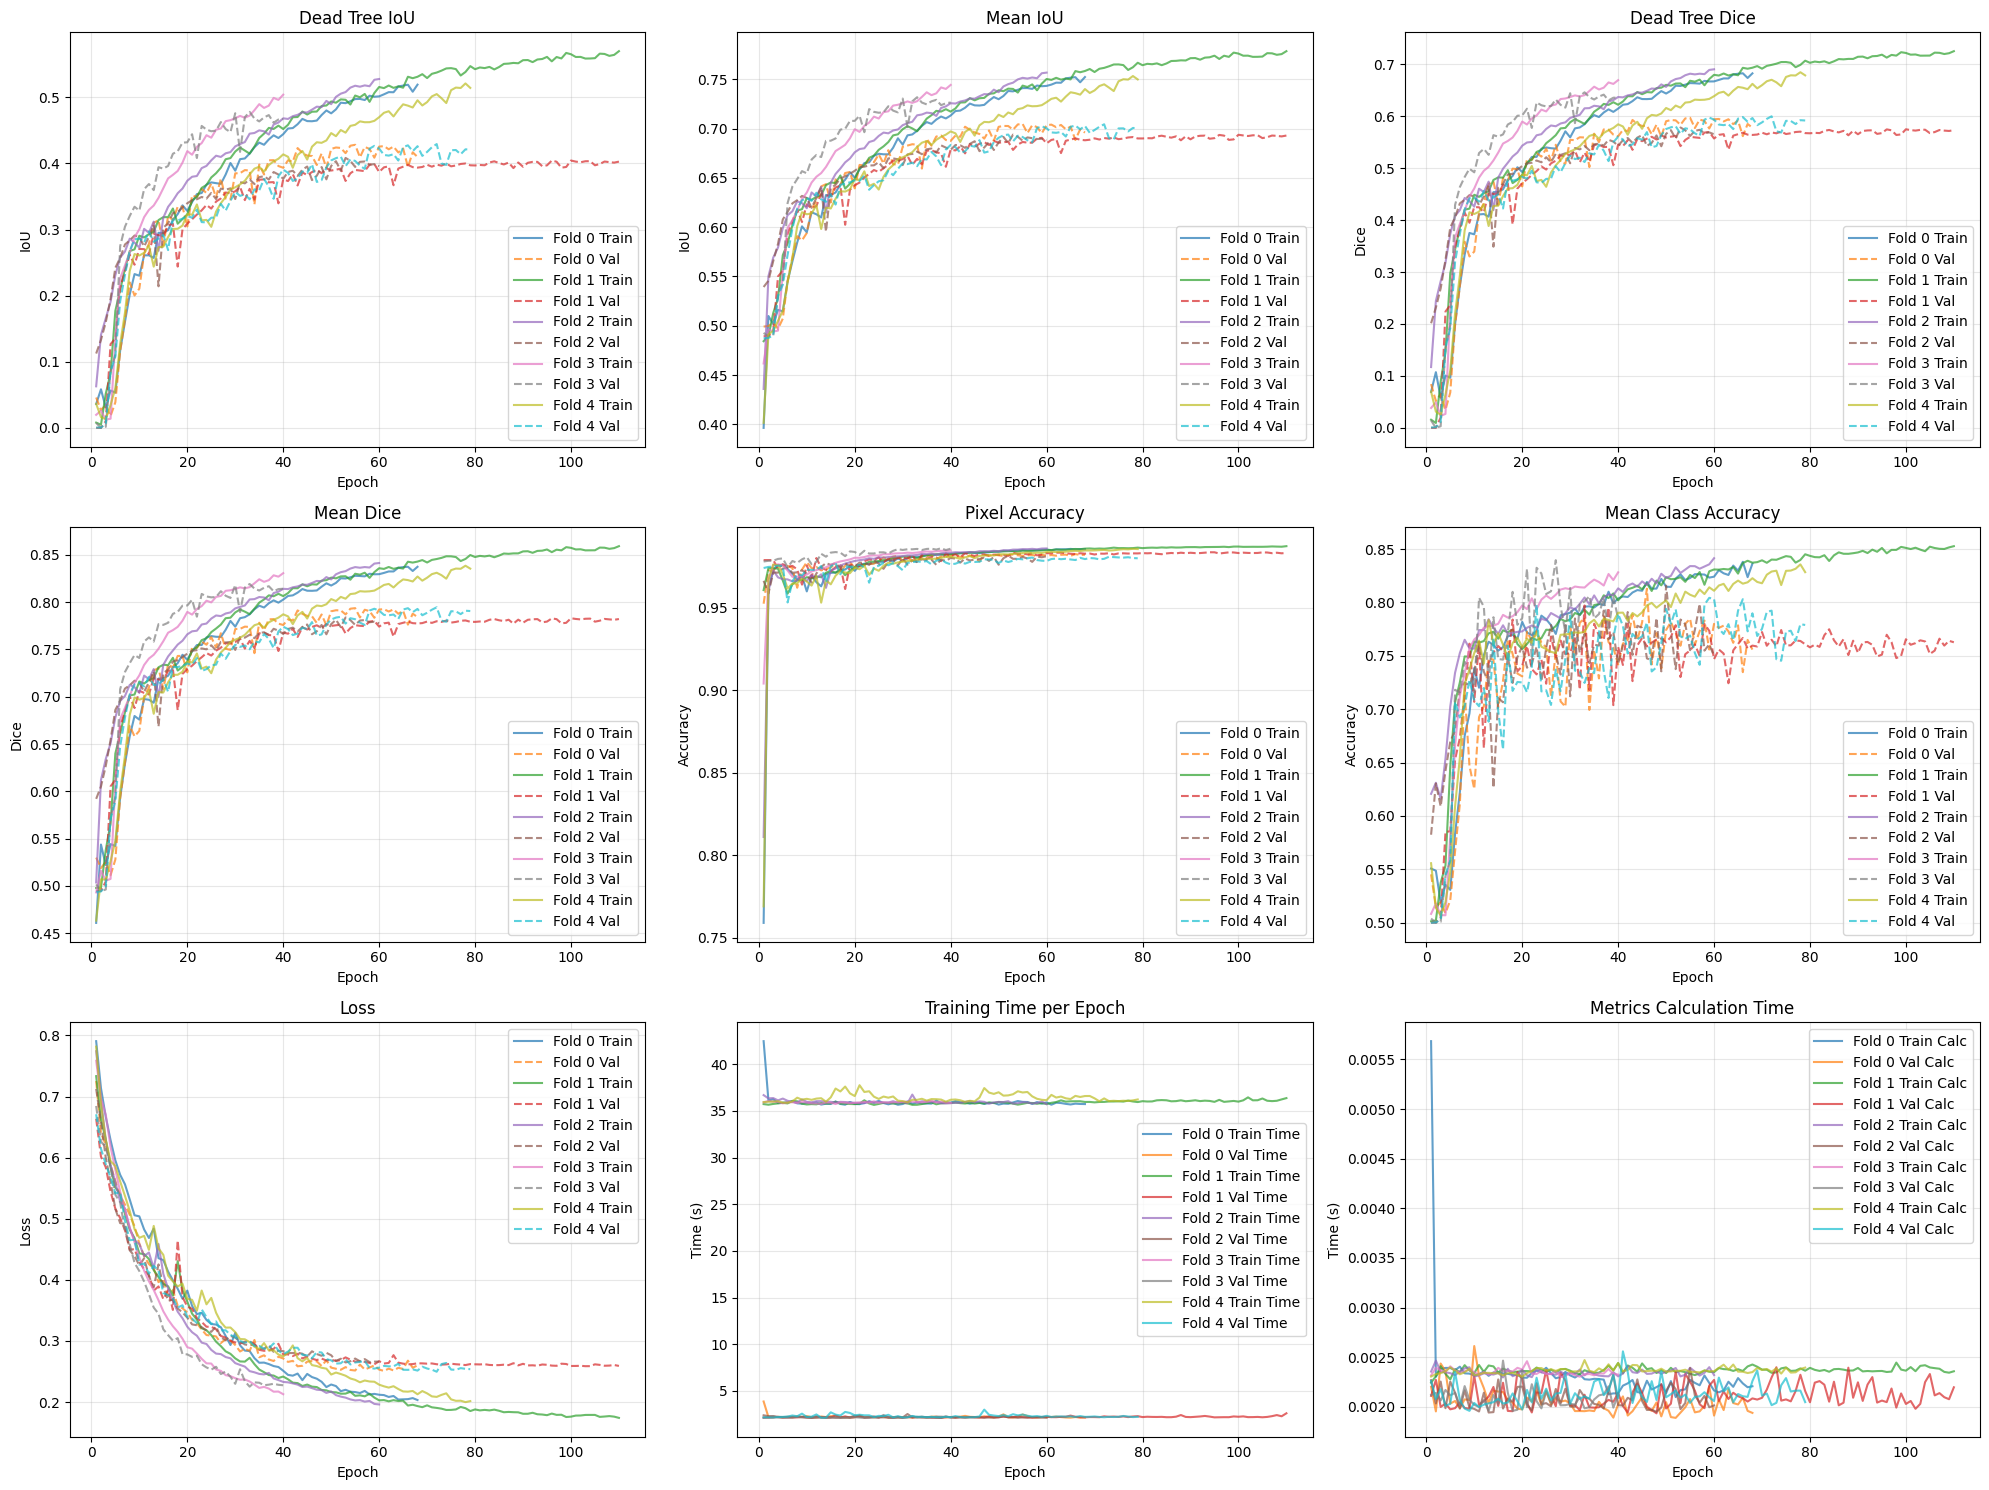


Generating comprehensive results summary...
COMPREHENSIVE CROSS-VALIDATION RESULTS SUMMARY

Detailed Results per Fold:
--------------------------------------------------------------------------------
 Fold  Val Loss  Dead Tree IoU  Mean IoU  Dead Tree Dice  Mean Dice  Pixel Accuracy  Mean Class Accuracy  Training Time (min)  Best Epoch
    0    0.2516         0.4282    0.7047          0.5969     0.7937          0.9815               0.7847              43.2957          55
    1    0.2590         0.4044    0.6937          0.5747     0.7830          0.9832               0.7655              69.9355         100
    2    0.2648         0.4083    0.6938          0.5781     0.7839          0.9797               0.7840              38.1803          53
    3    0.2252         0.4780    0.7317          0.6458     0.8192          0.9857               0.8010              25.4033          33
    4    0.2496         0.4292    0.7043          0.5997     0.7946          0.9797               0.7923     

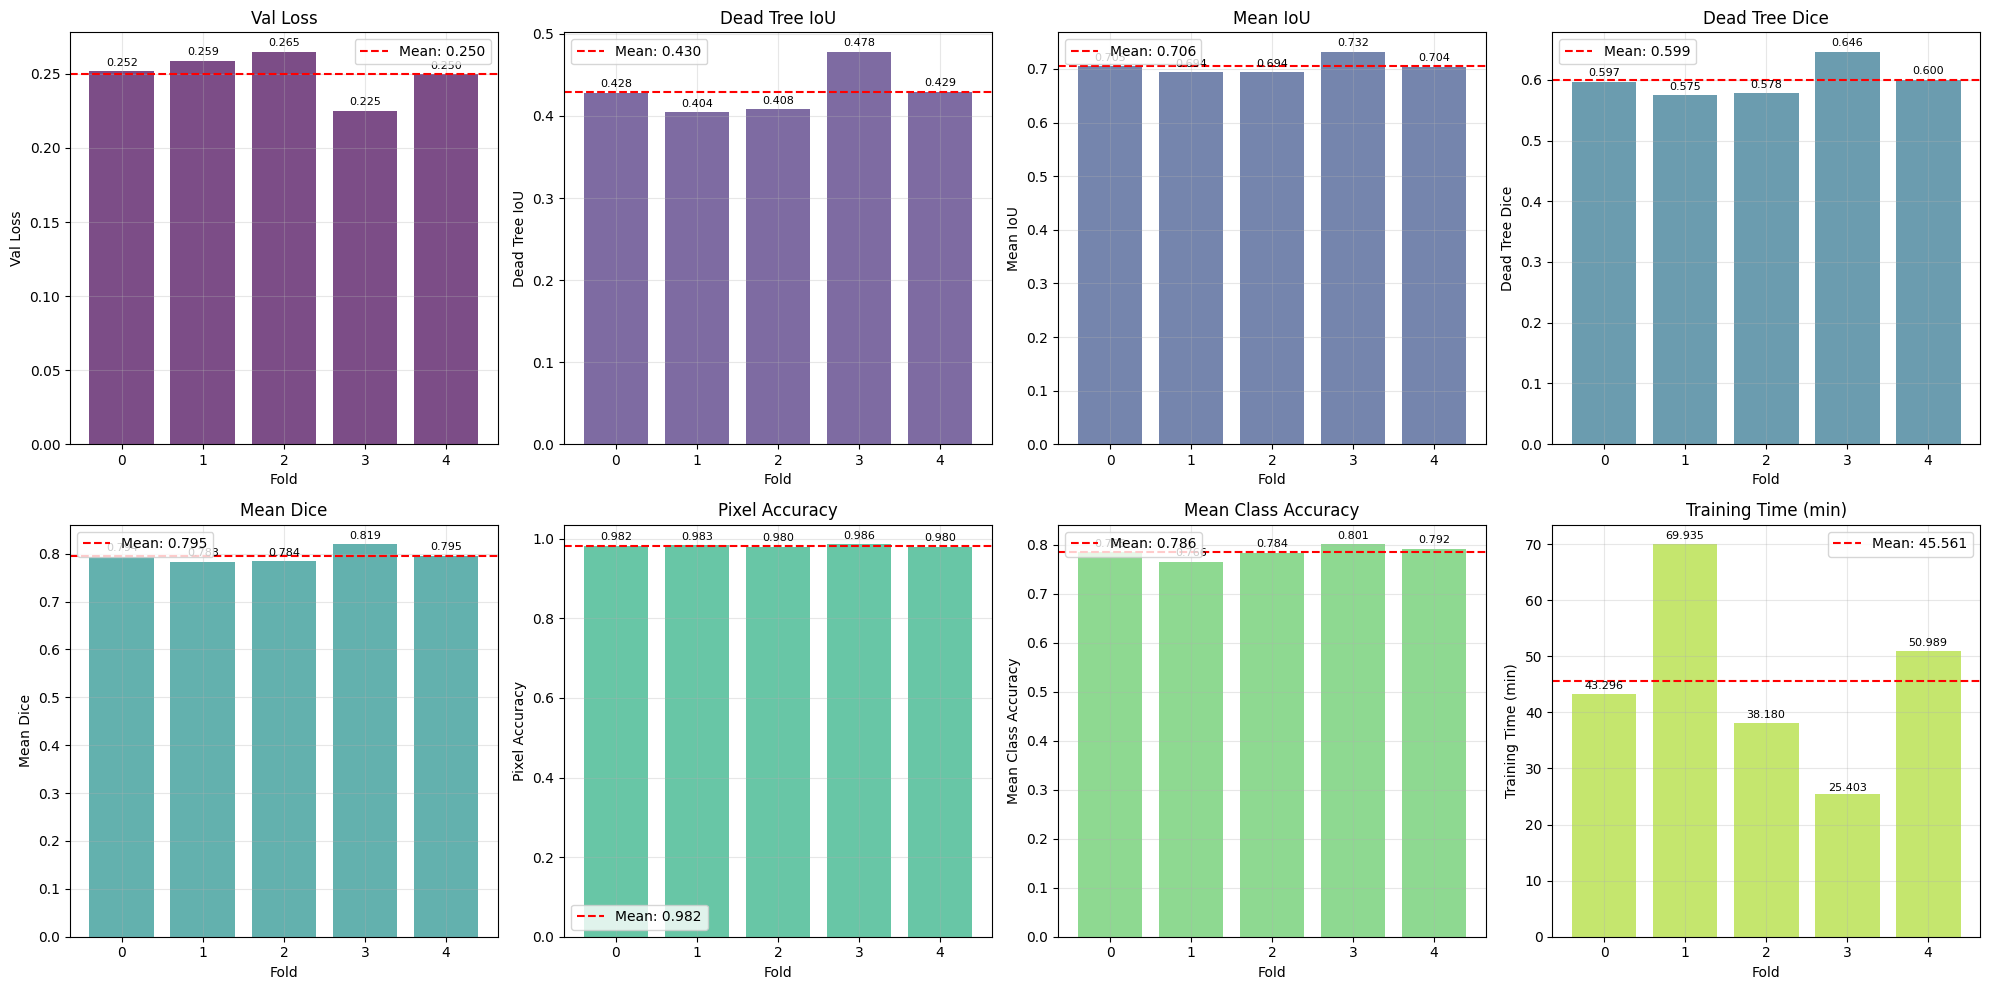

Metrics heatmap saved to /kaggle/working/cv_results_heatmap.png


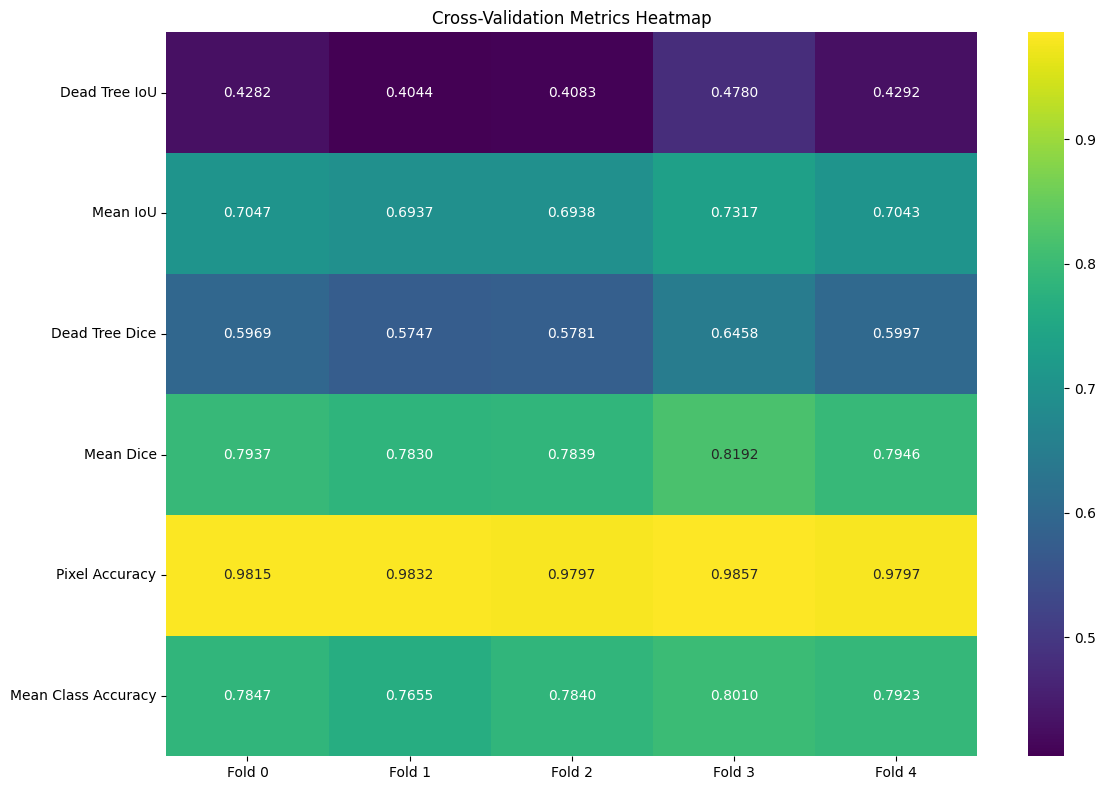

Results CSV saved to /kaggle/working/cv_results_results.csv


In [14]:
# Execute comprehensive analysis and visualization
if fold_results:
    print("Generating comprehensive training curves...")
    plot_comprehensive_training_curves(fold_results, save_path='/kaggle/working/training_curves.png')
    
    print("\nGenerating comprehensive results summary...")
    cv_results = summarize_comprehensive_cv_results(fold_results, save_path='/kaggle/working/cv_results.png')
else:
    print("No fold results available for analysis.")

## 10. Model Prediction Visualization

Visualizing predictions from best fold (Fold 3)


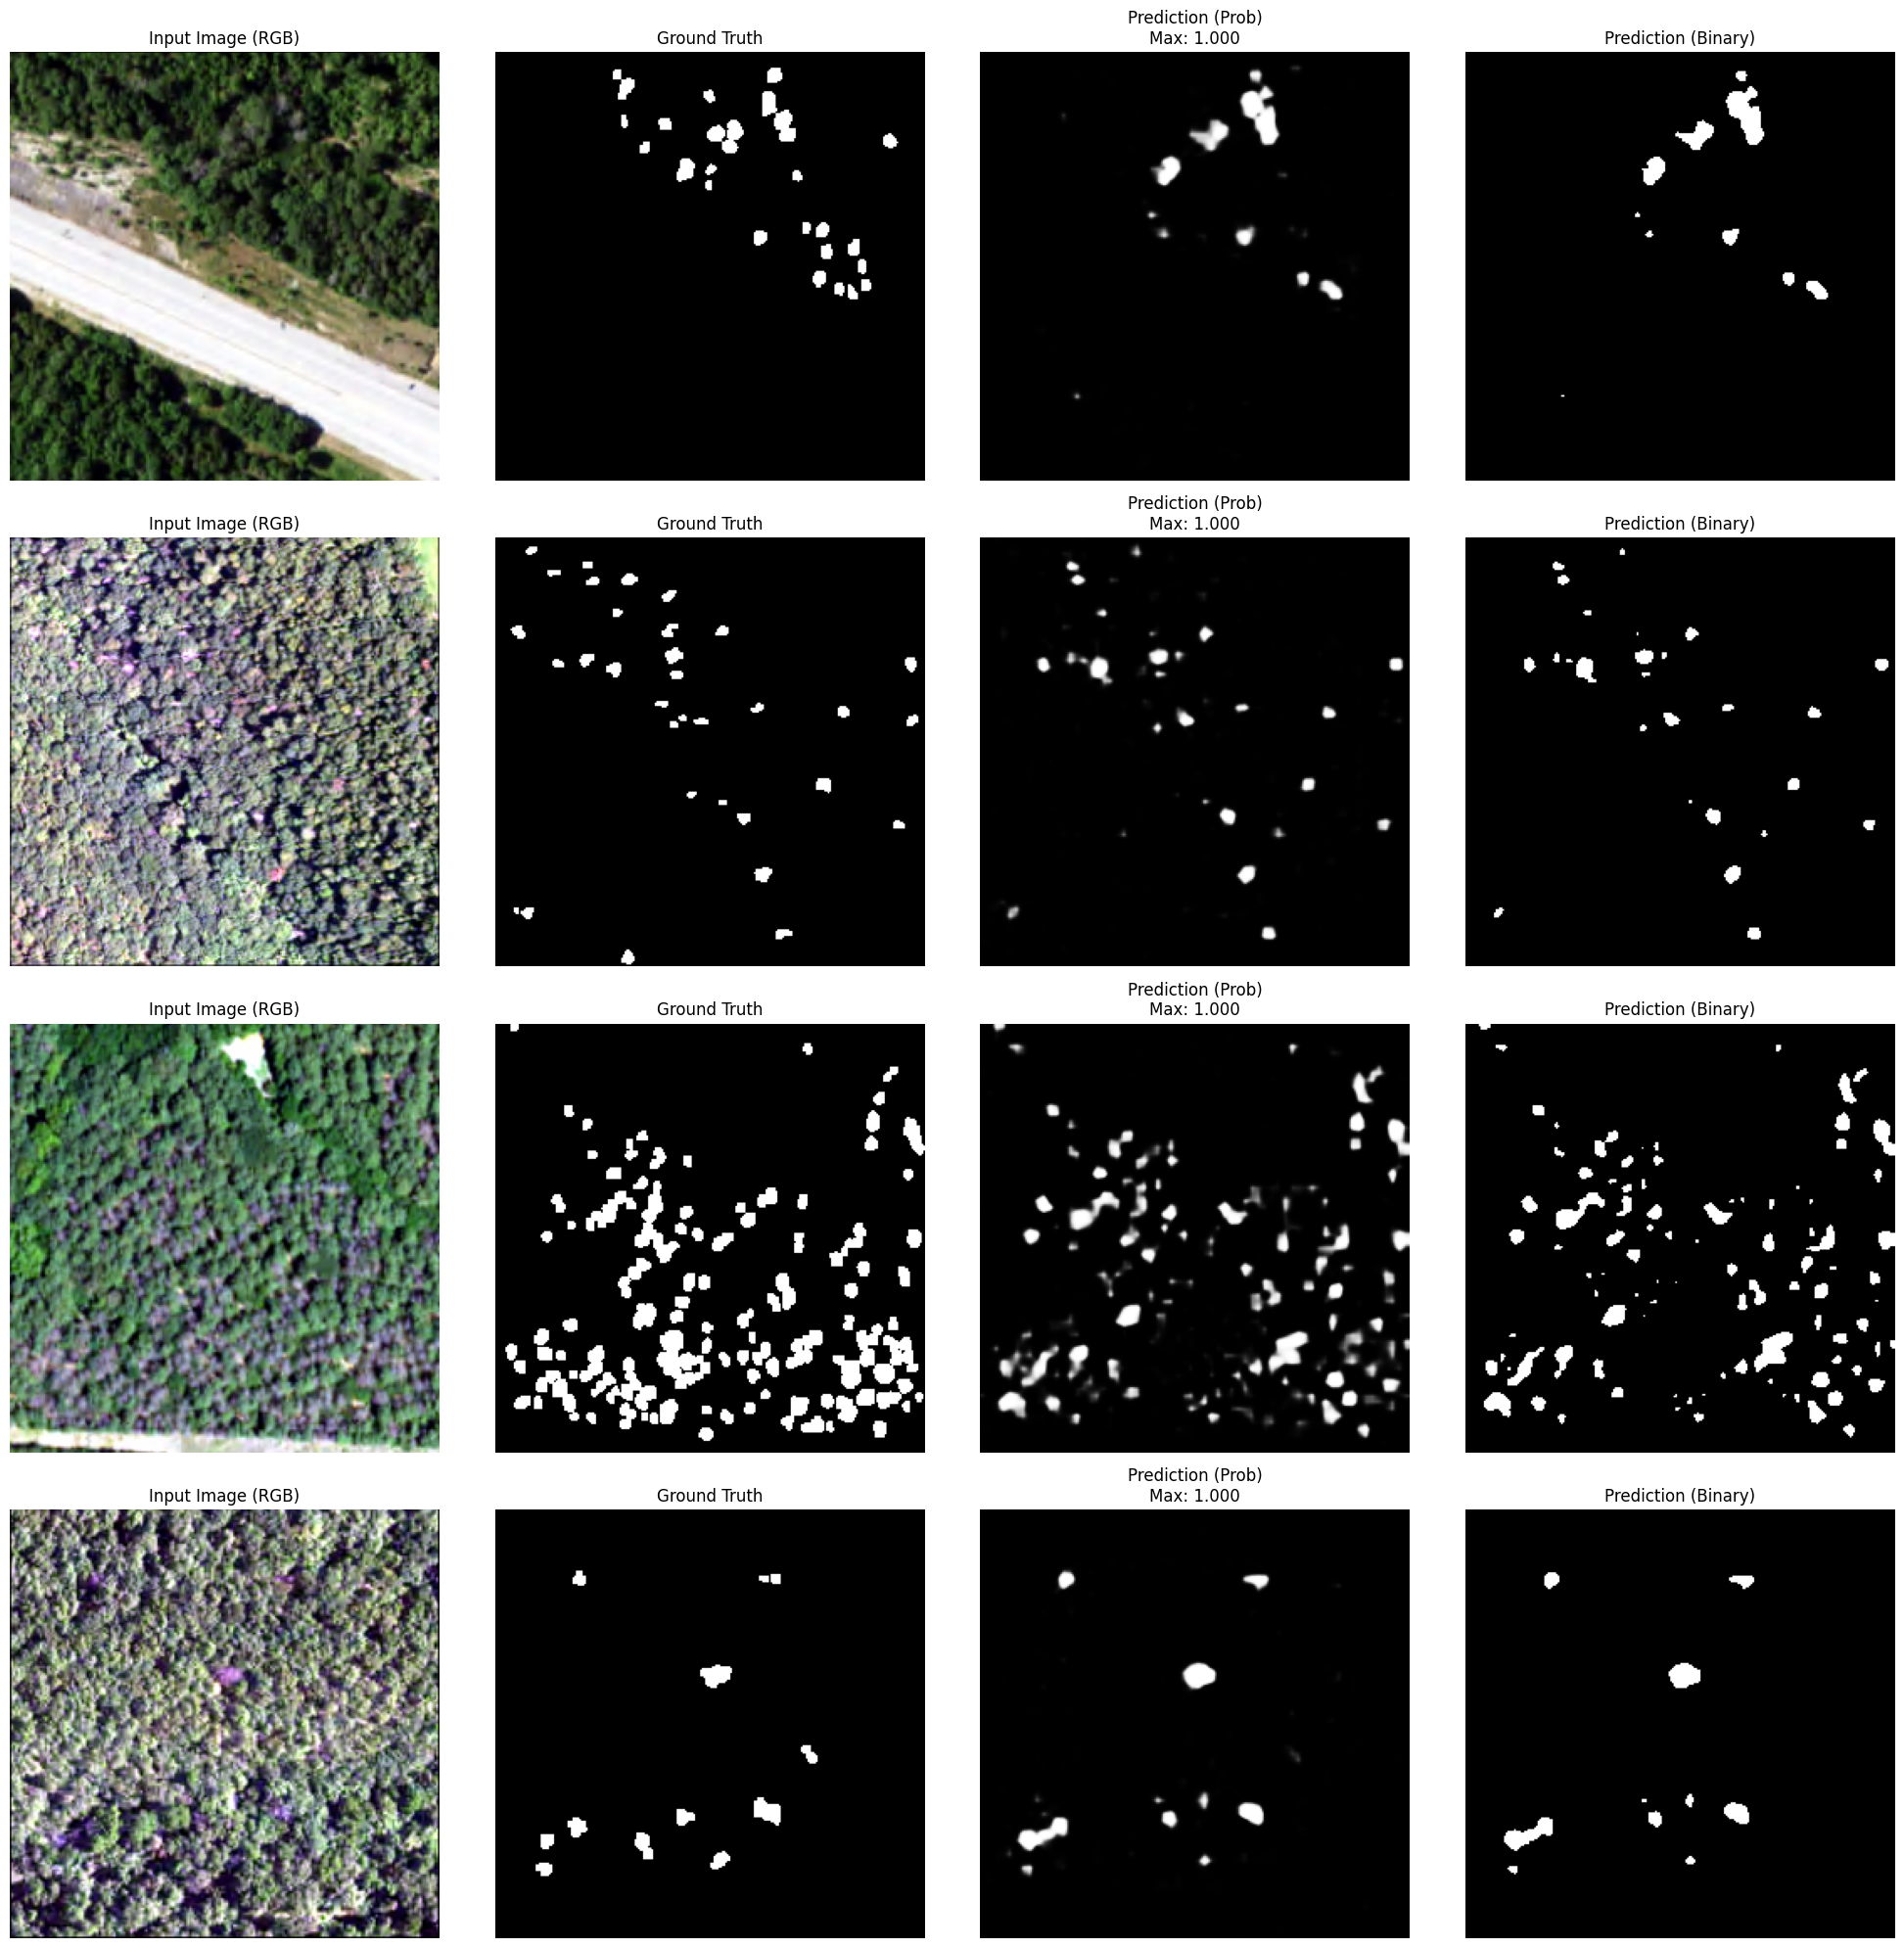

In [ ]:
def visualize_predictions(model, dataset, device, num_samples=4):
    """Visualize model prediction results"""
    model.eval()
    
    # Randomly select samples
    sample_indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5*num_samples))
    
    with torch.no_grad():
        for i, idx in enumerate(sample_indices):
            image, mask = dataset[idx]
            
            # Prediction
            image_input = image.unsqueeze(0).to(device)
            pred = model(image_input)  # Output: [1, 1, H, W]
            pred = pred.cpu().numpy()[0, 0]  # Convert to [H, W]
            
            # Denormalize image for display (only show first 3 channels RGB)
            image_np = image.numpy().transpose(1, 2, 0)
            if image_np.shape[2] == 4:
                # 4-channel case, only take first 3 channels for display
                image_np = image_np[:, :, :3]
            
            # Denormalize (only for RGB three channels)
            image_np = image_np * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
            image_np = np.clip(image_np, 0, 1)
            
            # Process mask display
            mask_np = mask.numpy()
            if mask_np.ndim == 3 and mask_np.shape[0] == 1:
                mask_np = mask_np[0]  # Convert from [1, H, W] to [H, W]
            
            # Generate binary prediction
            pred_binary = (pred > 0.5).astype(np.uint8)
            
            # Display images
            axes[i, 0].imshow(image_np)
            axes[i, 0].set_title('Input Image (RGB)')
            axes[i, 0].axis('off')
            
            axes[i, 1].imshow(mask_np, cmap='gray')
            axes[i, 1].set_title('Ground Truth')
            axes[i, 1].axis('off')
            
            axes[i, 2].imshow(pred, cmap='gray', vmin=0, vmax=1)
            # axes[i, 2].set_title(f'Prediction (Prob)\nMax: {pred.max():.3f}')
            axes[i, 2].set_title(f'Prediction (Prob)')
            axes[i, 2].axis('off')
            
            axes[i, 3].imshow(pred_binary, cmap='gray')
            axes[i, 3].set_title('Prediction')
            axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize best model prediction results
if fold_results:
    best_fold = max(fold_results, key=lambda x: x['best_mean_iou'])
    print(f"Visualizing predictions from best fold (Fold {best_fold['fold']})")
    
    # Create validation dataset
    input_channels = 4 if config['input_type'] == 'rgb_nir' else 3
    val_dataset = DeadTreeDataset(
        matched_files, 
        folds[best_fold['fold']]['val_idx'],
        input_type=config['input_type'],
        transform=get_transforms('val', input_channels=input_channels)
    )
    
    visualize_predictions(best_fold['model'], val_dataset, device)

## 11. Model Saving and Loading

In [16]:
# Enhanced model saving with comprehensive metrics
def save_best_model(fold_results, save_dir='/kaggle/working/models'):
    """Save best model with comprehensive metrics"""
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Find best model based on mean IoU
    best_fold = max(fold_results, key=lambda x: x['best_mean_iou'])
    
    # Prepare comprehensive metrics for saving
    comprehensive_metrics = {
        'best_val_loss': best_fold['best_val_loss'],
        'best_dead_tree_iou': best_fold['best_dead_tree_iou'],
        'best_mean_iou': best_fold['best_mean_iou'],
        'best_dead_tree_dice': best_fold['best_dead_tree_dice'],
        'best_mean_dice': best_fold['best_mean_dice'],
        'best_pixel_accuracy': best_fold['best_pixel_accuracy'],
        'best_mean_class_accuracy': best_fold['best_mean_class_accuracy'],
        'training_time': best_fold['training_time'],
        'best_epoch': best_fold['best_epoch']
    }
    
    # Save model with comprehensive information
    model_path = os.path.join(save_dir, 'best_segformer_model.pth')
    torch.save({
        'model_state_dict': best_fold['model'].state_dict(),
        'fold': best_fold['fold'],
        'config': config,
        'comprehensive_metrics': comprehensive_metrics,
        'save_timestamp': time.strftime('%Y-%m-%d %H:%M:%S'),
        'model_architecture': 'SegFormer-B3-4Channel'
    }, model_path)
    
    print(f"Best model saved to {model_path}")
    print(f"Best model from Fold {best_fold['fold']} with comprehensive metrics:")
    print(f"  Dead Tree IoU: {comprehensive_metrics['best_dead_tree_iou']:.4f}")
    print(f"  Mean IoU: {comprehensive_metrics['best_mean_iou']:.4f}")
    print(f"  Dead Tree Dice: {comprehensive_metrics['best_dead_tree_dice']:.4f}")
    print(f"  Mean Dice: {comprehensive_metrics['best_mean_dice']:.4f}")
    print(f"  Pixel Accuracy: {comprehensive_metrics['best_pixel_accuracy']:.4f}")
    print(f"  Mean Class Accuracy: {comprehensive_metrics['best_mean_class_accuracy']:.4f}")
    print(f"  Training Time: {comprehensive_metrics['training_time']/60:.1f} minutes")
    print(f"  Best Epoch: {comprehensive_metrics['best_epoch']}")
    
    return model_path

# Enhanced training history saving
def save_comprehensive_training_history(fold_results, save_dir='/kaggle/working/models'):
    """Save comprehensive training history"""
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    # Save each fold's detailed history
    for fold_result in fold_results:
        history_path = os.path.join(save_dir, f'fold_{fold_result["fold"]}_comprehensive_history.csv')
        
        # Convert history to DataFrame, handling different lengths
        history_df_data = {}
        for key, values in fold_result['history'].items():
            if isinstance(values, list):
                history_df_data[key] = values
        
        if history_df_data:  # Only save if there's data
            history_df = pd.DataFrame(dict([(k, pd.Series(v)) for k, v in history_df_data.items()]))
            history_df.to_csv(history_path, index=False)
            print(f"Fold {fold_result['fold']} history saved to {history_path}")
    
    # Save comprehensive summary results
    if 'cv_results' in globals():
        summary_path = os.path.join(save_dir, 'comprehensive_cv_summary.csv')
        cv_results.to_csv(summary_path, index=False)
        print(f"Comprehensive CV summary saved to {summary_path}")
    
    # Save timing summary
    timing_summary = []
    for fold_result in fold_results:
        timing_data = {
            'fold': fold_result['fold'],
            'total_training_time_min': fold_result['training_time'] / 60,
            'best_epoch': fold_result['best_epoch'],
            'avg_time_per_epoch_min': (fold_result['training_time'] / 60) / fold_result['best_epoch']
        }
        if 'history' in fold_result and 'total_train_time' in fold_result['history']:
            timing_data['train_time_min'] = fold_result['history']['total_train_time'] / 60
            timing_data['val_time_min'] = fold_result['history']['total_val_time'] / 60
        timing_summary.append(timing_data)
    
    timing_df = pd.DataFrame(timing_summary)
    timing_path = os.path.join(save_dir, 'training_timing_summary.csv')
    timing_df.to_csv(timing_path, index=False)
    print(f"Training timing summary saved to {timing_path}")
    
    print(f"All training history saved to {save_dir}")

# Load model function with comprehensive metrics
def load_model_with_metrics(model_path, device='cuda'):
    """Load model with comprehensive metrics"""
    checkpoint = torch.load(model_path, map_location=device)
    
    # Create model with same configuration
    config = checkpoint['config']
    model = create_model(config['input_type'], device)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    print(f"Model loaded from {model_path}")
    print(f"Model from Fold {checkpoint['fold']}")
    
    if 'comprehensive_metrics' in checkpoint:
        metrics = checkpoint['comprehensive_metrics']
        print(f"Comprehensive metrics:")
        for key, value in metrics.items():
            if 'time' in key.lower():
                if 'training_time' in key:
                    print(f"  {key}: {value/60:.1f} minutes")
                else:
                    print(f"  {key}: {value:.4f}")
            elif 'epoch' in key:
                print(f"  {key}: {value}")
            else:
                print(f"  {key}: {value:.4f}")
    
    if 'save_timestamp' in checkpoint:
        print(f"Saved at: {checkpoint['save_timestamp']}")
    
    return model, checkpoint

# Save model and history with comprehensive metrics
if fold_results:
    print("Saving best model with comprehensive metrics...")
    model_path = save_best_model(fold_results)
    
    print("\nSaving comprehensive training history...")
    save_comprehensive_training_history(fold_results)
    
    print(f"\nAll files saved successfully!")
else:
    print("No fold results available for saving.")

Saving best model with comprehensive metrics...
Best model saved to /kaggle/working/models/best_segformer_model.pth
Best model from Fold 3 with comprehensive metrics:
  Dead Tree IoU: 0.4780
  Mean IoU: 0.7317
  Dead Tree Dice: 0.6458
  Mean Dice: 0.8192
  Pixel Accuracy: 0.9857
  Mean Class Accuracy: 0.8010
  Training Time: 25.4 minutes
  Best Epoch: 33

Saving comprehensive training history...
Fold 0 history saved to /kaggle/working/models/fold_0_comprehensive_history.csv
Fold 1 history saved to /kaggle/working/models/fold_1_comprehensive_history.csv
Fold 2 history saved to /kaggle/working/models/fold_2_comprehensive_history.csv
Fold 3 history saved to /kaggle/working/models/fold_3_comprehensive_history.csv
Fold 4 history saved to /kaggle/working/models/fold_4_comprehensive_history.csv
Comprehensive CV summary saved to /kaggle/working/models/comprehensive_cv_summary.csv
Training timing summary saved to /kaggle/working/models/training_timing_summary.csv
All training history saved to /